# Visualización de objetos de estudio


In [12]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import *
import matplotlib.pyplot as plt
import pyrosm
from pyrosm.data import sources
from shapely import wkt
import seaborn as sns

sns.set(palette='viridis', context='notebook', font_scale=1.0, font='DejaVu Sans')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Se lee el archivo csv generado con los pois a estudiar

In [2]:
amenity_pois = pd.read_csv('/home/jsepulveda/files/amenity_points.csv')
amenity_pois['geometry'] = amenity_pois['geometry'].apply(wkt.loads)
amenity_gdf = gpd.GeoDataFrame(amenity_pois, crs='epsg:4326')


### Se lee el archivo con los shapes de distritos urbanos y comunas urbanas

In [3]:
urban_distritos = gpd.read_file('/home/jsepulveda/urban_distritos.shp')
urban_comunas = gpd.read_file('/home/jsepulveda/urban_comunas.shp')
urban_comunas.head()

REGION                        NOM_REGION  PROVINCIA NOM_PROVIN  COMUNA  \
0      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13124   
1      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13103   
2      13  REGIÓN METROPOLITANA DE SANTIAGO        133  CHACABUCO   13302   
3      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13107   
4      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13104   

    NOM_COMUNA  SHAPE_Leng  SHAPE_Area  \
0     PUDAHUEL    0.720176    0.019124   
1  CERRO NAVIA    0.170180    0.001076   
2        LAMPA    1.046716    0.043569   
3   HUECHURABA    0.326251    0.004350   
4     CONCHALÍ    0.138248    0.001077   

                                            geometry  
0  POLYGON ((-70.78216 -33.41714, -70.78216 -33.4...  
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...  
2  POLYGON ((-70.71901 -33.32442, -70.71902 -33.3...  
3  POLYGON ((-70.60223 -33.38550, -70.60222 -33.3...  
4  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...

### Se lee el archivo con las torres y sus ubicaciones

In [4]:
torres = pd.read_csv('/home/jsepulveda/torres_clean.csv')
torres['geometry'] = torres['geometry'].apply(wkt.loads)
torres_gdf = gpd.GeoDataFrame(torres, crs='epsg:4326')
torres_gdf.head()

rinhead                     geometry   NOM_COMUNA
0   11SEP  POINT (-70.61111 -33.42227)  PROVIDENCIA
1   ALBER  POINT (-70.63374 -33.43539)  PROVIDENCIA
2   ATICF  POINT (-70.60563 -33.42468)  PROVIDENCIA
3   AVIUM  POINT (-70.62628 -33.44031)  PROVIDENCIA
4   BARRO  POINT (-70.61785 -33.43059)  PROVIDENCIA

### Se lee el archivo con la ruta de la L6 del Metro de Santiago

In [5]:
ruta = pd.read_csv('/home/jsepulveda/files/l6_route.csv')
ruta['geometry'] = ruta['geometry'].apply(wkt.loads)
ruta_gdf = gpd.GeoDataFrame(ruta, crs='epsg:4326')

### Se visualiza toda la información recopilada, el mapa de la RM dividido por comunas y distritos con los pois de recreación y eduación, las torres, y finalmente la Línea 6 del Metro de Santiago

In [6]:
import matplotlib.patheffects as path_effects

try:
    from adjustText import adjust_text
except:
    adjust_text = lambda *x,**y: x
    

text_style = dict(horizontalalignment='center', fontsize=13, fontweight='bold'
                 ,color='white', fontstretch='condensed')
text_effects = [path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()]    

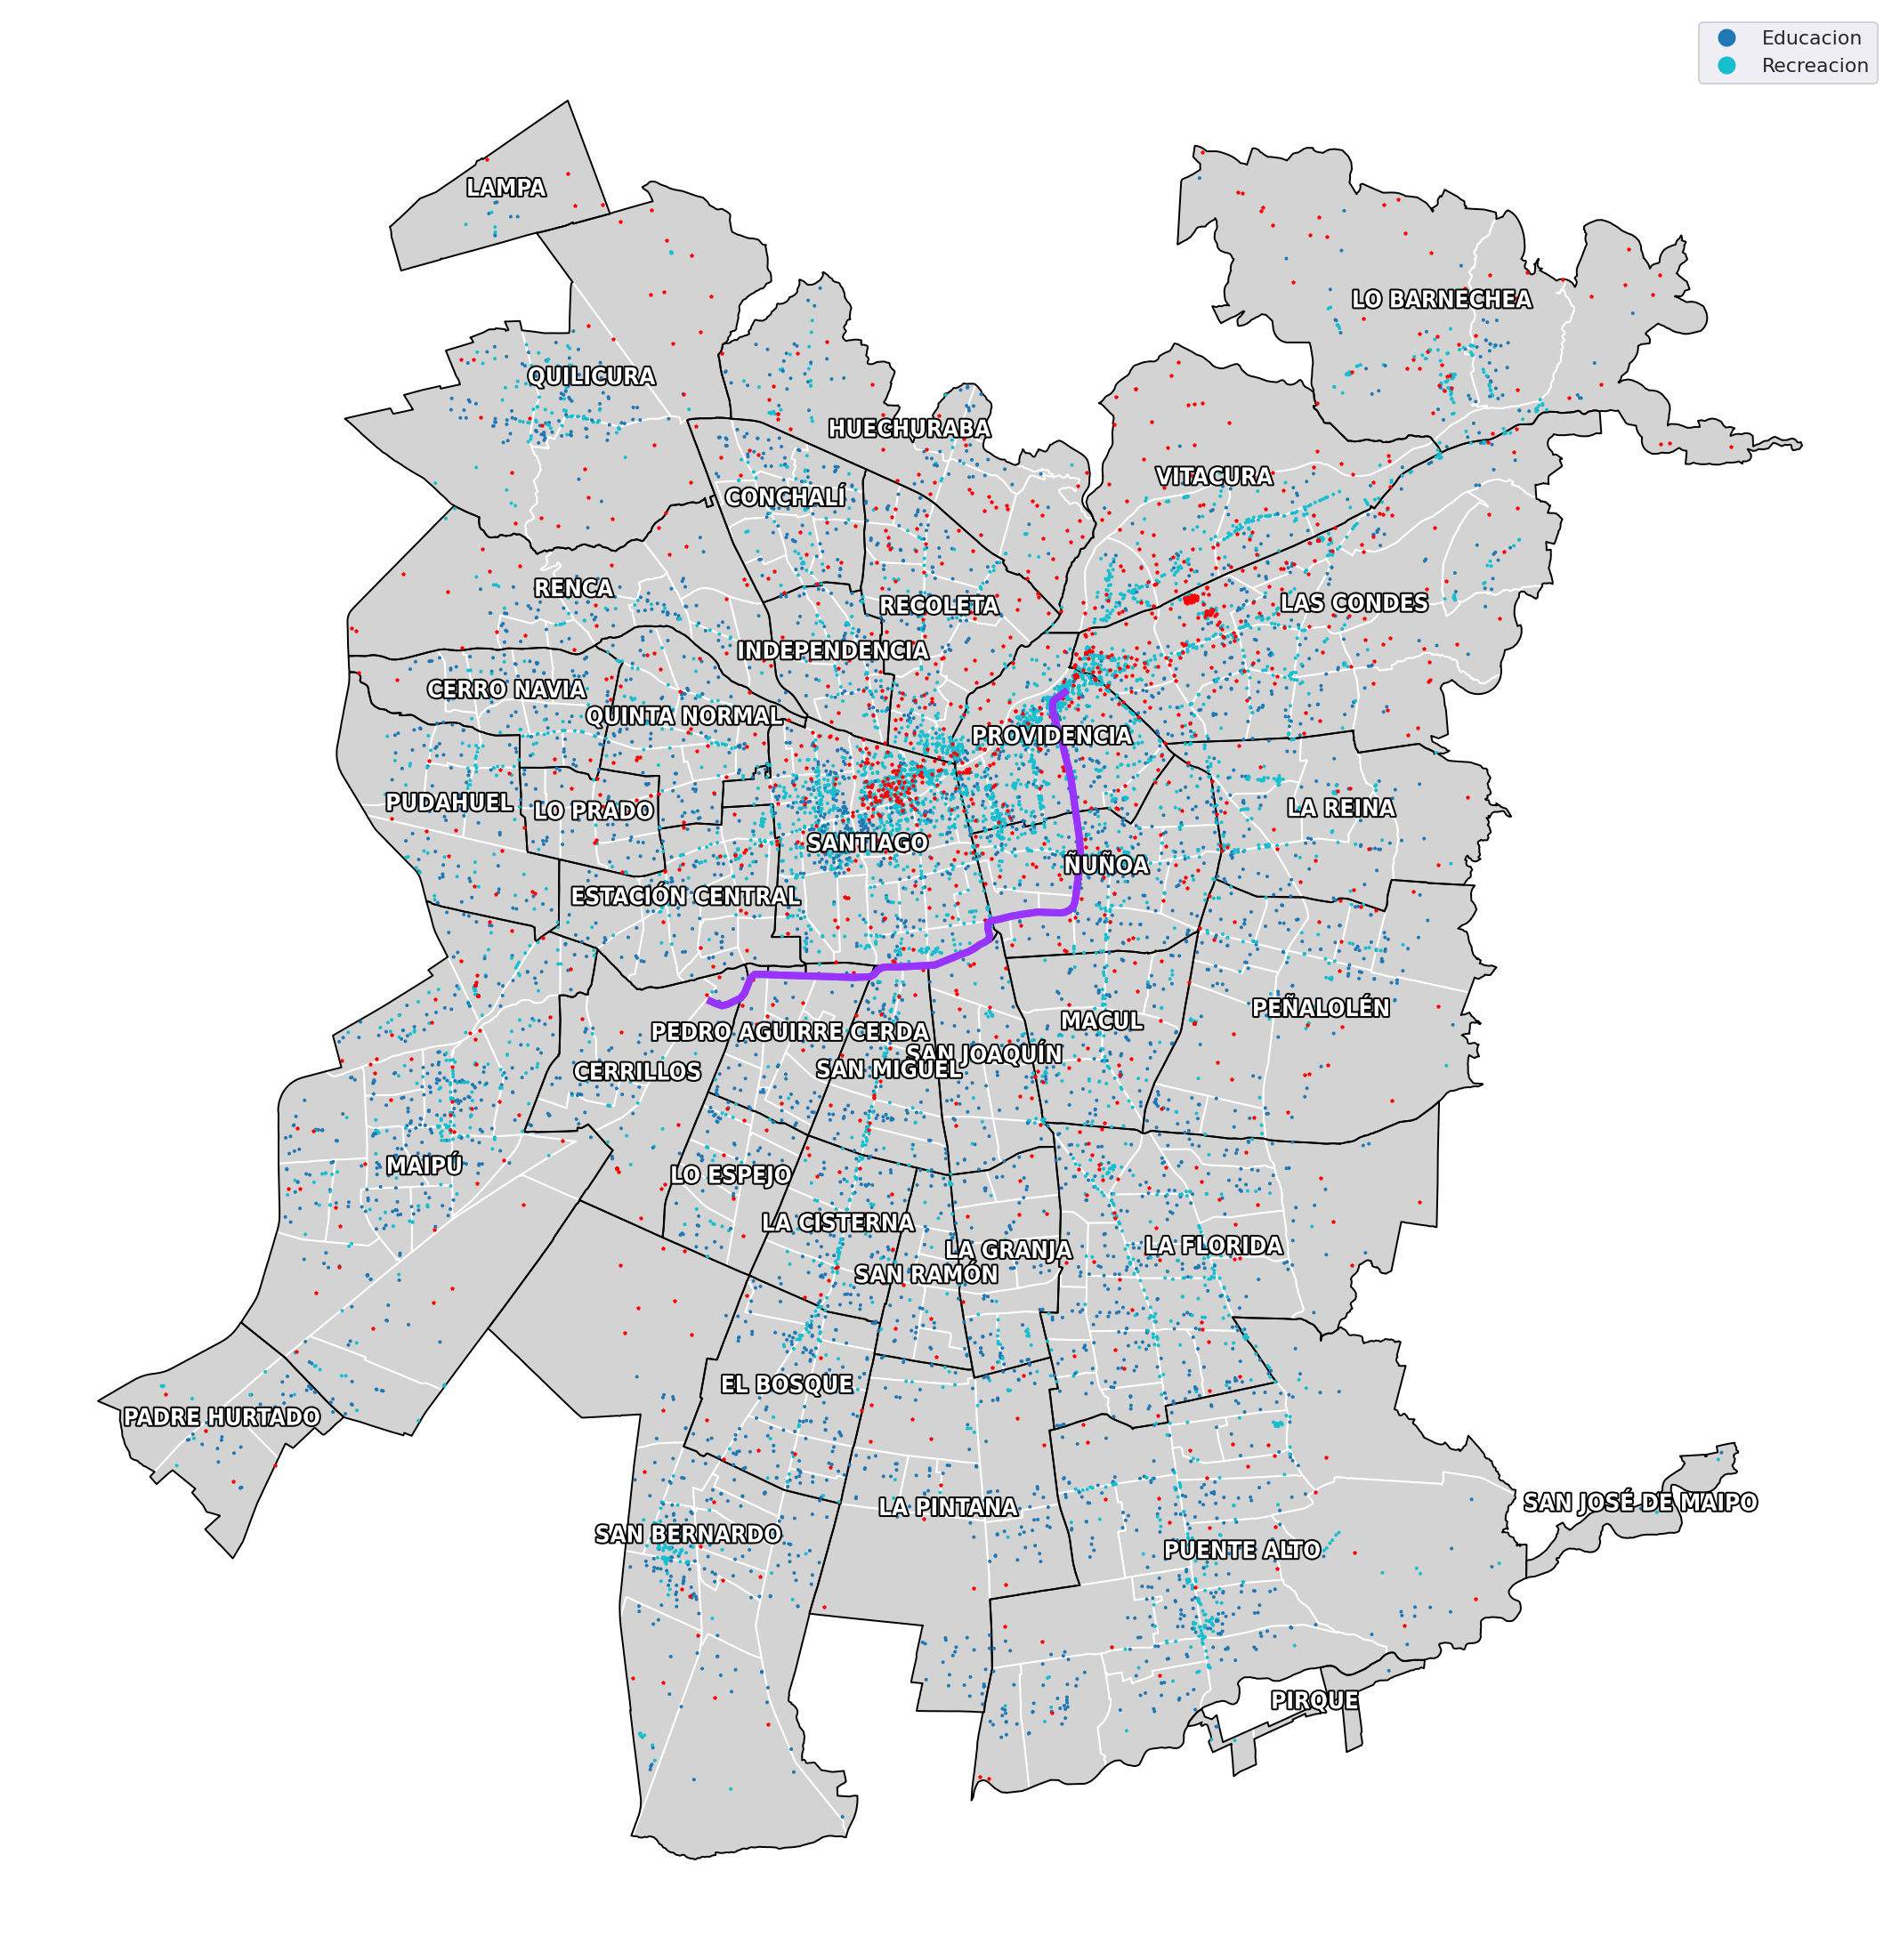

In [13]:
ax = urban_distritos.plot(figsize=(20,20),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = urban_comunas.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = amenity_gdf.plot(column='amenity', figsize=(20,20),markersize=1,legend=True,ax=ax)
ax = torres_gdf.plot(marker='*', color='red',markersize=2,ax=ax)
ax = ruta_gdf.plot(color='#'+ ruta_gdf.route_color,linewidth=4,ax=ax)


texts = []
for comuna, centroid in zip(urban_comunas['NOM_COMUNA'], urban_comunas.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

# ###############################################################

### Se analiza por cada elemento del mapa, POIs de Educación, Recreación y Torres

In [17]:
urban_distritos = urban_distritos.set_crs("EPSG:4326")
urban_distritos_educacion = gpd.sjoin(amenity_gdf,urban_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)

indexNames = urban_distritos_educacion[(urban_distritos_educacion['amenity'] != 'Educacion')].index
urban_distritos_educacion.drop(indexNames, inplace=True)
columnas_delete_e = ['Unnamed: 0', 'id', 'changeset', 'lat', 'timestamp', 'tags', 'version',
       'lon', 'addr:city', 'addr:country', 'addr:full', 'addr:housenumber',
       'addr:housename', 'addr:postcode', 'addr:street', 'email', 'name',
       'opening_hours', 'operator', 'phone', 'ref', 'website',
       'atm', 'bicycle_parking', 'bar', 'building', 'building:levels',
       'drinking_water', 'internet_access', 'landuse', 'office', 'parking',
       'social_facility', 'source', 'start_date', 'wikipedia', 'car',
       'clothes', 'craft', 'organic', 'religion', 'second_hand', 'shoes',
       'shop', 'trade', 'attraction', 'guest_house', 'information', 'museum',
       'tourism', 'zoo', 'geometry', 'osm_type', 'cafe', 'school', 'water',
       'wholesale', 'REGION', 'NOM_REGION', 'PROVINCIA', 'NOM_PROVIN',
       'NOM_COMUNA', 'TIPO_DISTR', 'SHAPE_Leng',
       'SHAPE_Area']

urban_distritos_e = urban_distritos_educacion.drop(columnas_delete_e, axis = 1)
pois_e_distritos = urban_distritos_e.groupby(['COMUNA','COD_DISTRI']).count().unstack(fill_value=0).stack()
pois_e_distritos.rename(columns={'amenity':'Educacion'}, inplace = True)
pois_e_distritos.head()

Educacion
COMUNA COD_DISTRI           
13101  1                   3
       2                   6
       3                   6
       4                  25
       5                  18

In [19]:
urban_distritos = urban_distritos.set_crs("EPSG:4326")
urban_distritos_recreacion = gpd.sjoin(amenity_gdf,urban_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
indexNames = urban_distritos_recreacion[(urban_distritos_recreacion['amenity'] != 'Recreacion')].index
urban_distritos_recreacion.drop(indexNames, inplace=True)
columnas_delete_r = ['Unnamed: 0', 'id', 'changeset', 'lat', 'timestamp', 'tags', 'version',
       'lon', 'addr:city', 'addr:country', 'addr:full', 'addr:housenumber',
       'addr:housename', 'addr:postcode', 'addr:street', 'email', 'name',
       'opening_hours', 'operator', 'phone', 'ref', 'website',
       'atm', 'bicycle_parking', 'bar', 'building', 'building:levels',
       'drinking_water', 'internet_access', 'landuse', 'office', 'parking',
       'social_facility', 'source', 'start_date', 'wikipedia', 'car',
       'clothes', 'craft', 'organic', 'religion', 'second_hand', 'shoes',
       'shop', 'trade', 'attraction', 'guest_house', 'information', 'museum',
       'tourism', 'zoo', 'geometry', 'osm_type', 'cafe', 'school', 'water',
       'wholesale', 'REGION', 'NOM_REGION', 'PROVINCIA', 'NOM_PROVIN',
       'NOM_COMUNA', 'TIPO_DISTR', 'SHAPE_Leng',
       'SHAPE_Area']

urban_distritos_r = urban_distritos_recreacion.drop(columnas_delete_r, axis = 1)
pois_r_distritos = urban_distritos_r.groupby(['COMUNA','COD_DISTRI']).count().unstack(fill_value=0).stack()
pois_r_distritos.rename(columns={'amenity':'Recreacion'}, inplace = True)
pois_r_distritos.head()

Recreacion
COMUNA COD_DISTRI            
13101  1                  142
       2                  169
       3                   21
       4                   63
       5                   34

In [20]:
urban_distritos = urban_distritos.set_crs("EPSG:4326")
urban_distritos_torres = gpd.sjoin(torres_gdf,urban_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
columnas_delete = ['geometry', 'NOM_COMUNA_left', 'REGION', 'NOM_REGION',
       'PROVINCIA', 'NOM_PROVIN', 'NOM_COMUNA_right',
       'TIPO_DISTR', 'SHAPE_Leng', 'SHAPE_Area']
urban_distritos_t = urban_distritos_torres.drop(columnas_delete, axis = 1)
torres_distritos = urban_distritos_t.groupby(['COMUNA','COD_DISTRI']).count().unstack(fill_value=0).stack()
torres_distritos.rename(columns={'rinhead':'Torres'}, inplace = True)
torres_distritos.head()

Torres
COMUNA COD_DISTRI        
13101  1               16
       2               70
       3               14
       4                3
       5                1

### Juntamos los 3 Dataframes creados

In [21]:
data = pd.concat([pois_e_distritos,pois_r_distritos, torres_distritos], axis=1).fillna(0).astype(np.int)
data.to_csv('/home/jsepulveda/files/data_count.csv')
data.head()

Educacion  Recreacion  Torres
COMUNA COD_DISTRI                               
13101  1                   3         142      16
       2                   6         169      70
       3                   6          21      14
       4                  25          63       3
       5                  18          34       1

In [23]:
urban_distritos = gpd.read_file('/home/jsepulveda/urban_distritos.shp').set_index(['COMUNA','COD_DISTRI'])


In [24]:
def plot_distritos(df, column=None, title=None, legend=True, cmap='BuPu', scheme='quantiles'):
    ax = urban_distritos.join(df).plot(figsize=(20,20), linewidth=1, edgecolor='white', column=column, legend=legend, scheme=scheme, cmap=cmap)
    ax = urban_comunas.plot(linewidth=2, edgecolor='black', facecolor="none", ax=ax)

    texts = []
    for comuna, centroid in zip(urban_comunas['NOM_COMUNA'], urban_comunas.centroid):
        t = ax.text(centroid.x, centroid.y, comuna, **text_style)
        t.set_path_effects(text_effects)
        texts.append(t)
    adjust_text(texts, autoalign='y', lim=1)
    ax.set_title(title,fontsize=20)
    ax.axis('off')

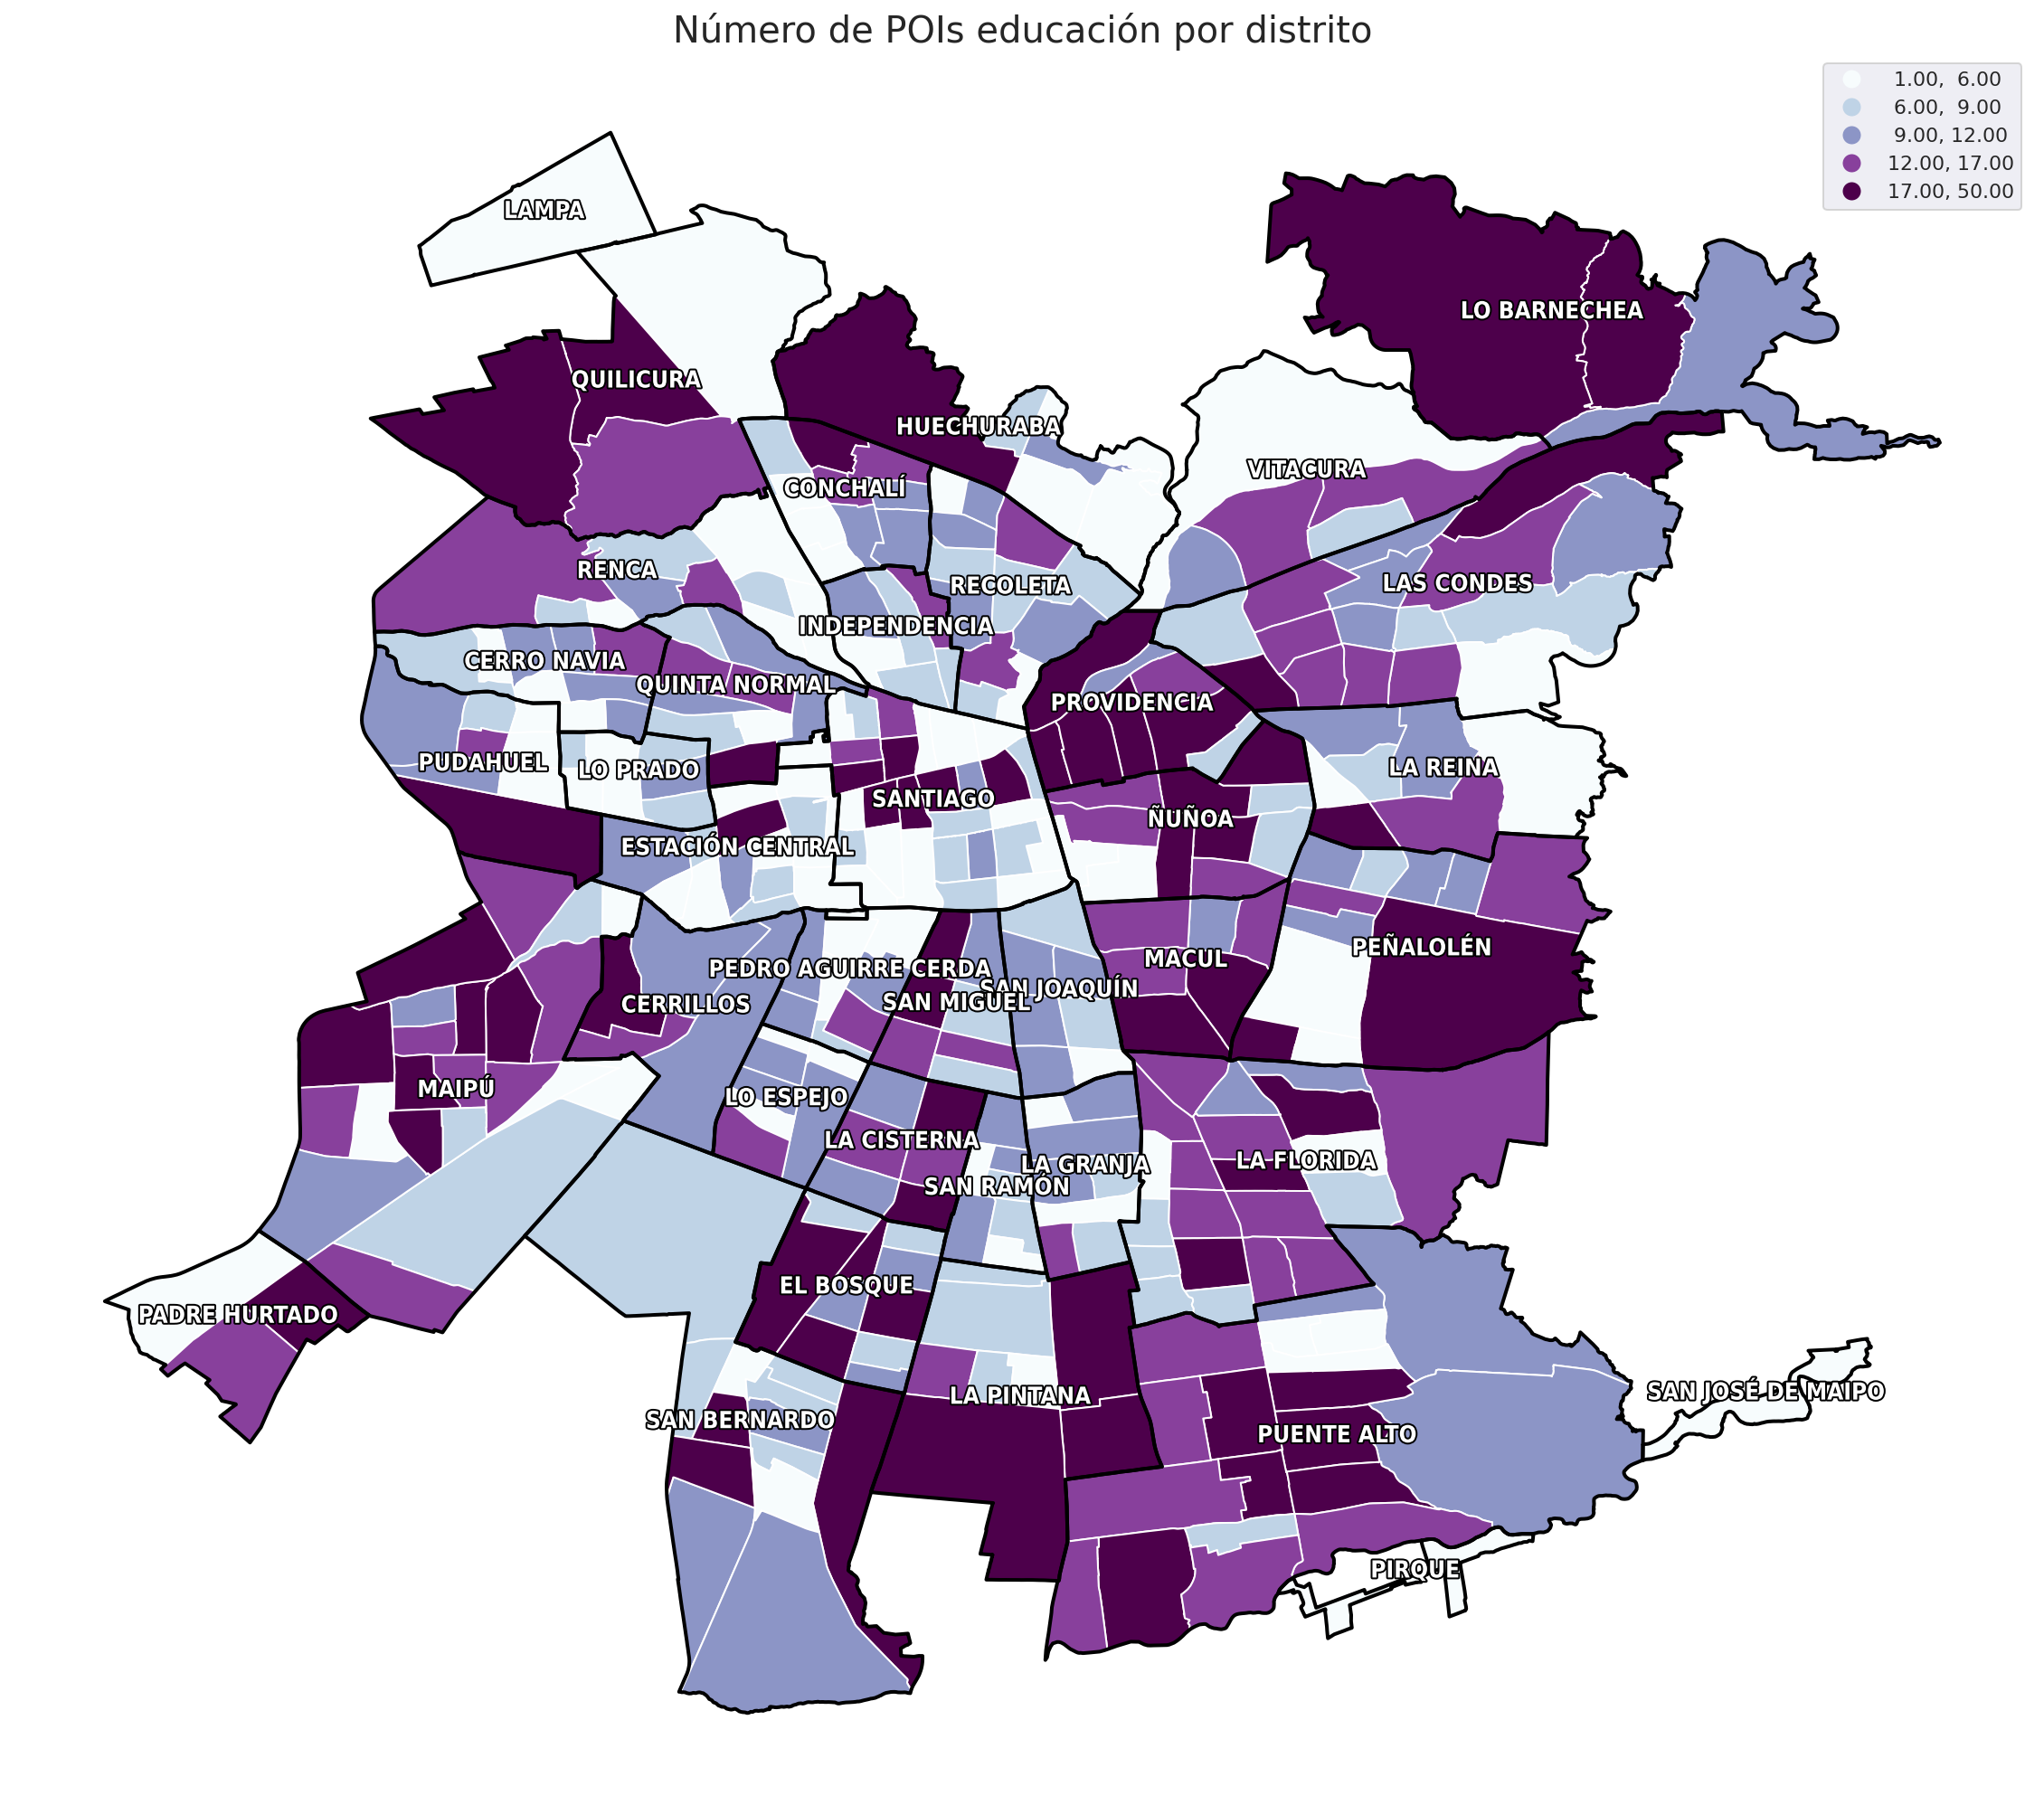

In [29]:
plot_distritos(data, column='Educacion', title='Número de POIs educación por distrito')
plt.savefig('/home/jsepulveda/images/pois_educacion_distritos.png', dpi=150, bbox_inches='tight');

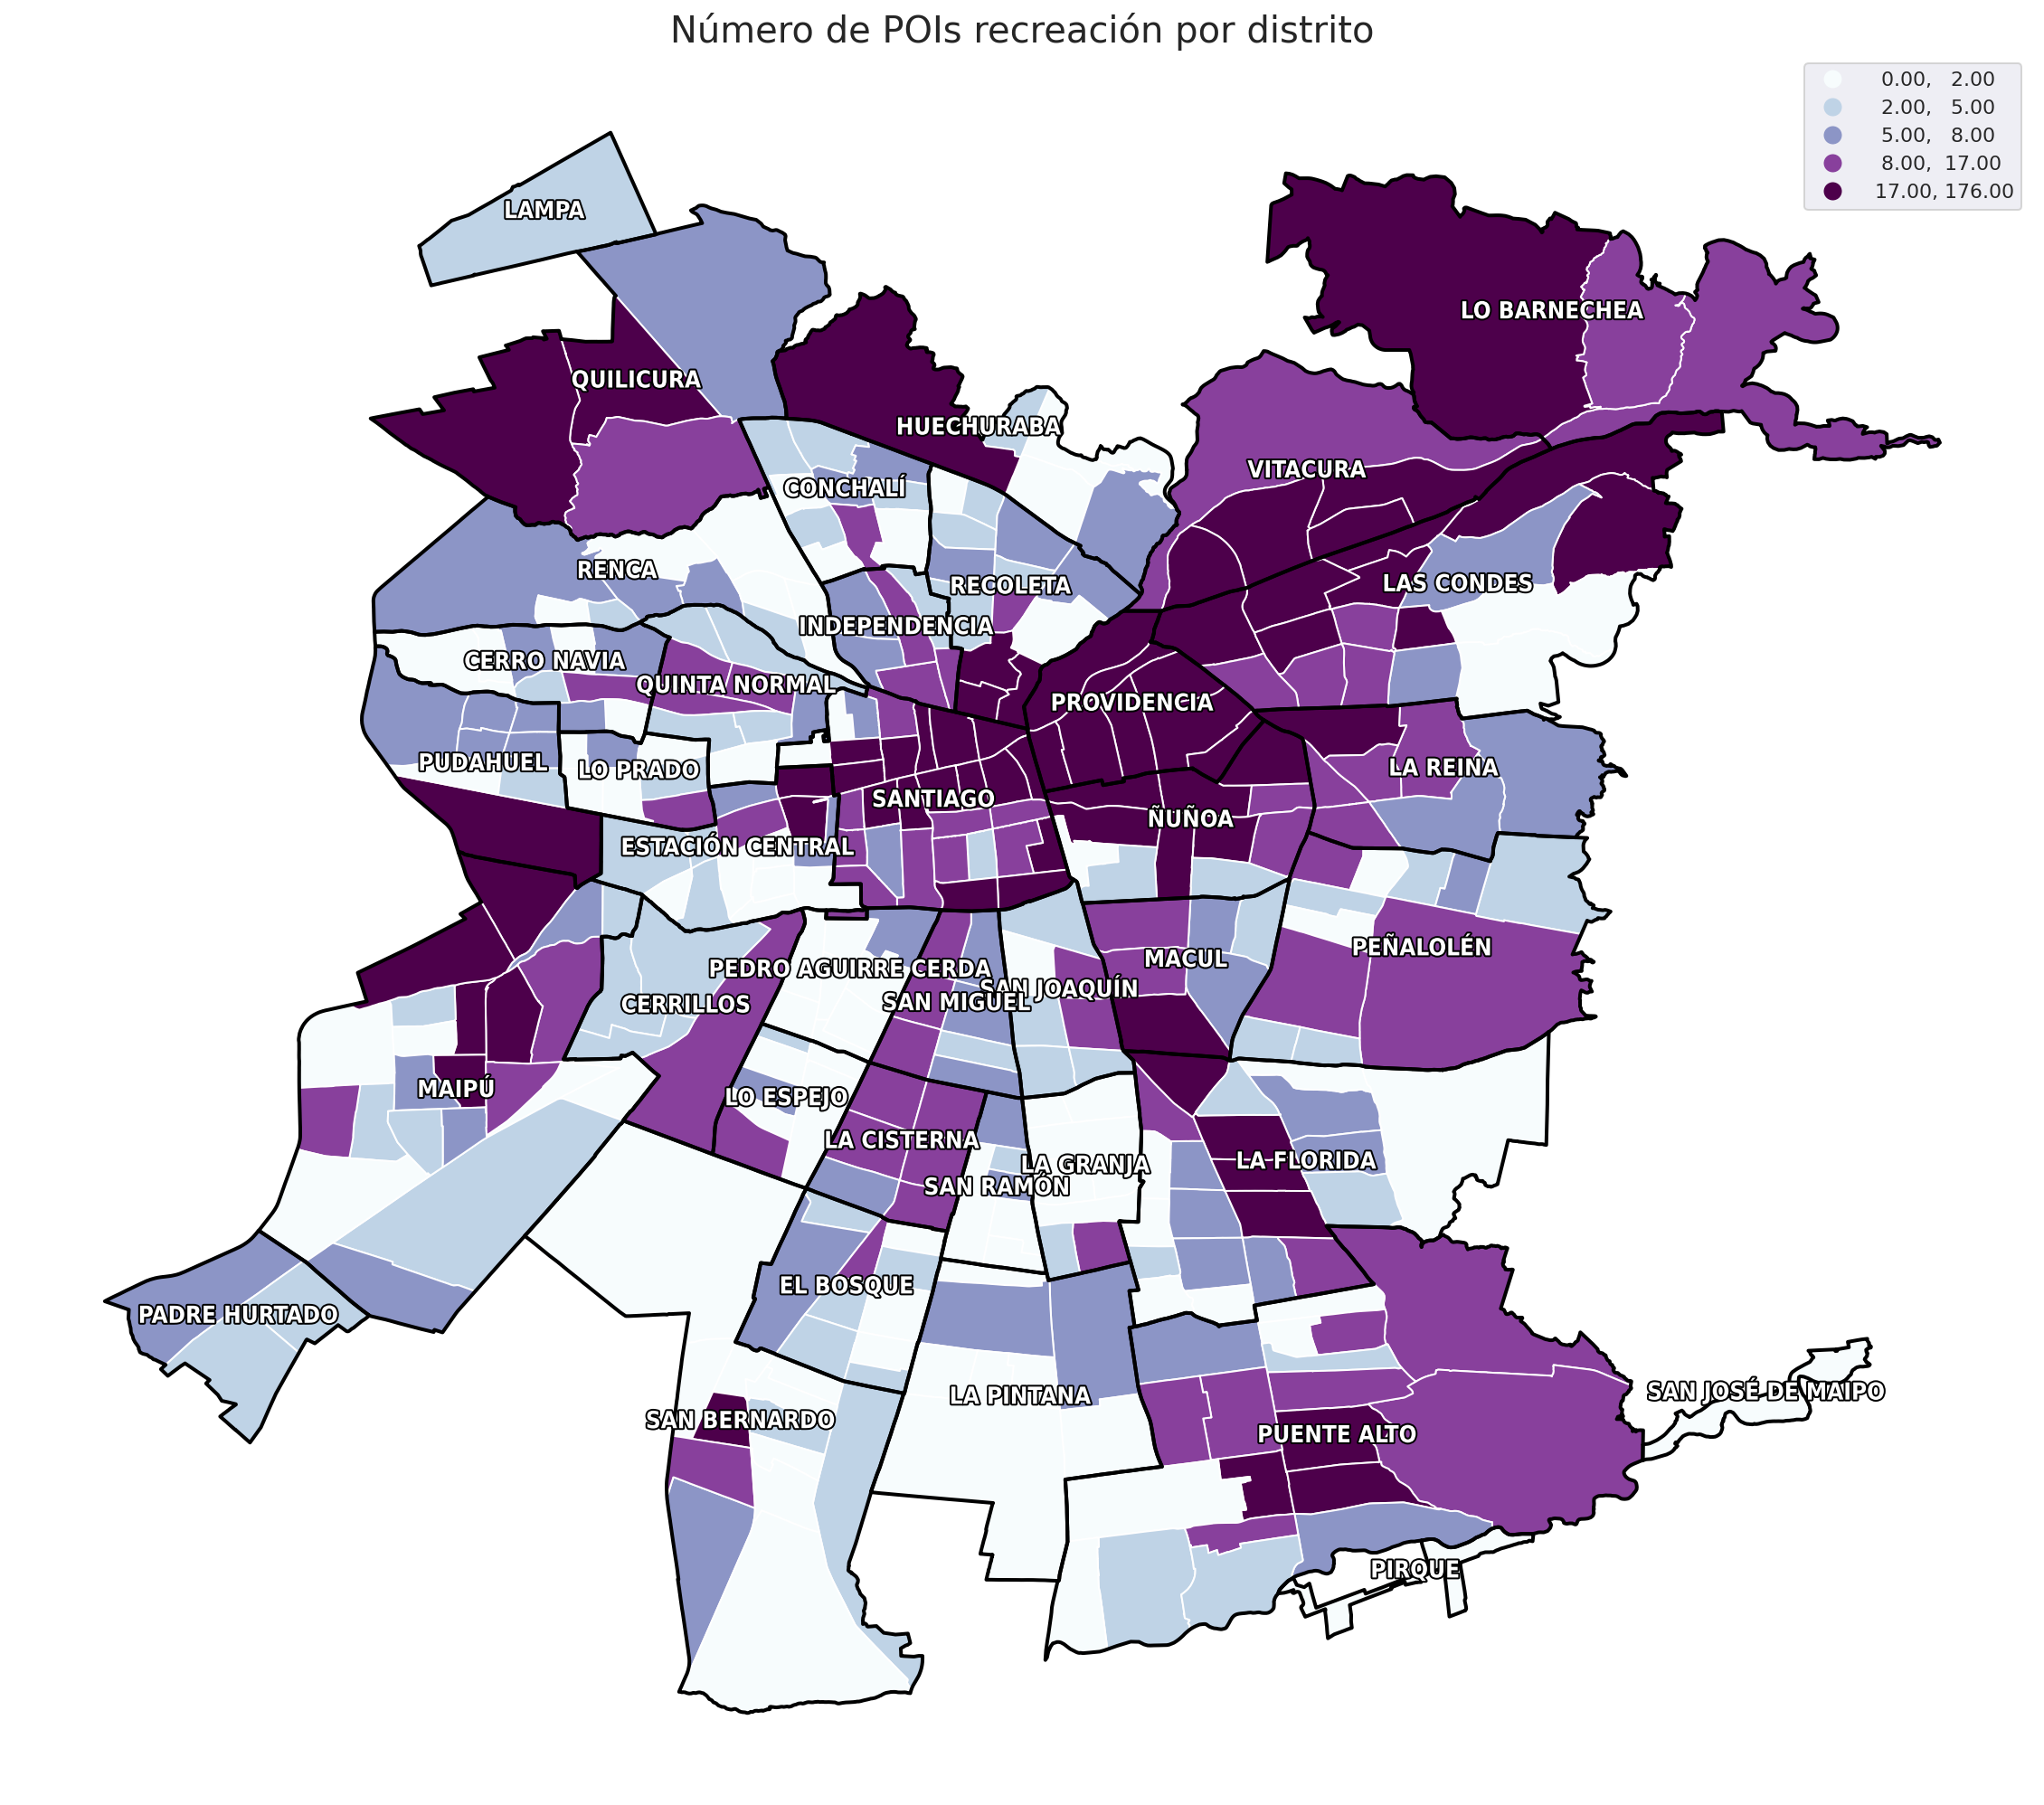

In [30]:
plot_distritos(data, column='Recreacion', title='Número de POIs recreación por distrito')
plt.savefig('/home/jsepulveda/images/pois_recreacion_distritos.png', dpi=150, bbox_inches='tight');

/home/jsepulveda/miniconda3/envs/myenv/lib/python3.9/site-packages/mapclassify/classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/home/jsepulveda/miniconda3/envs/myenv/lib/python3.9/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


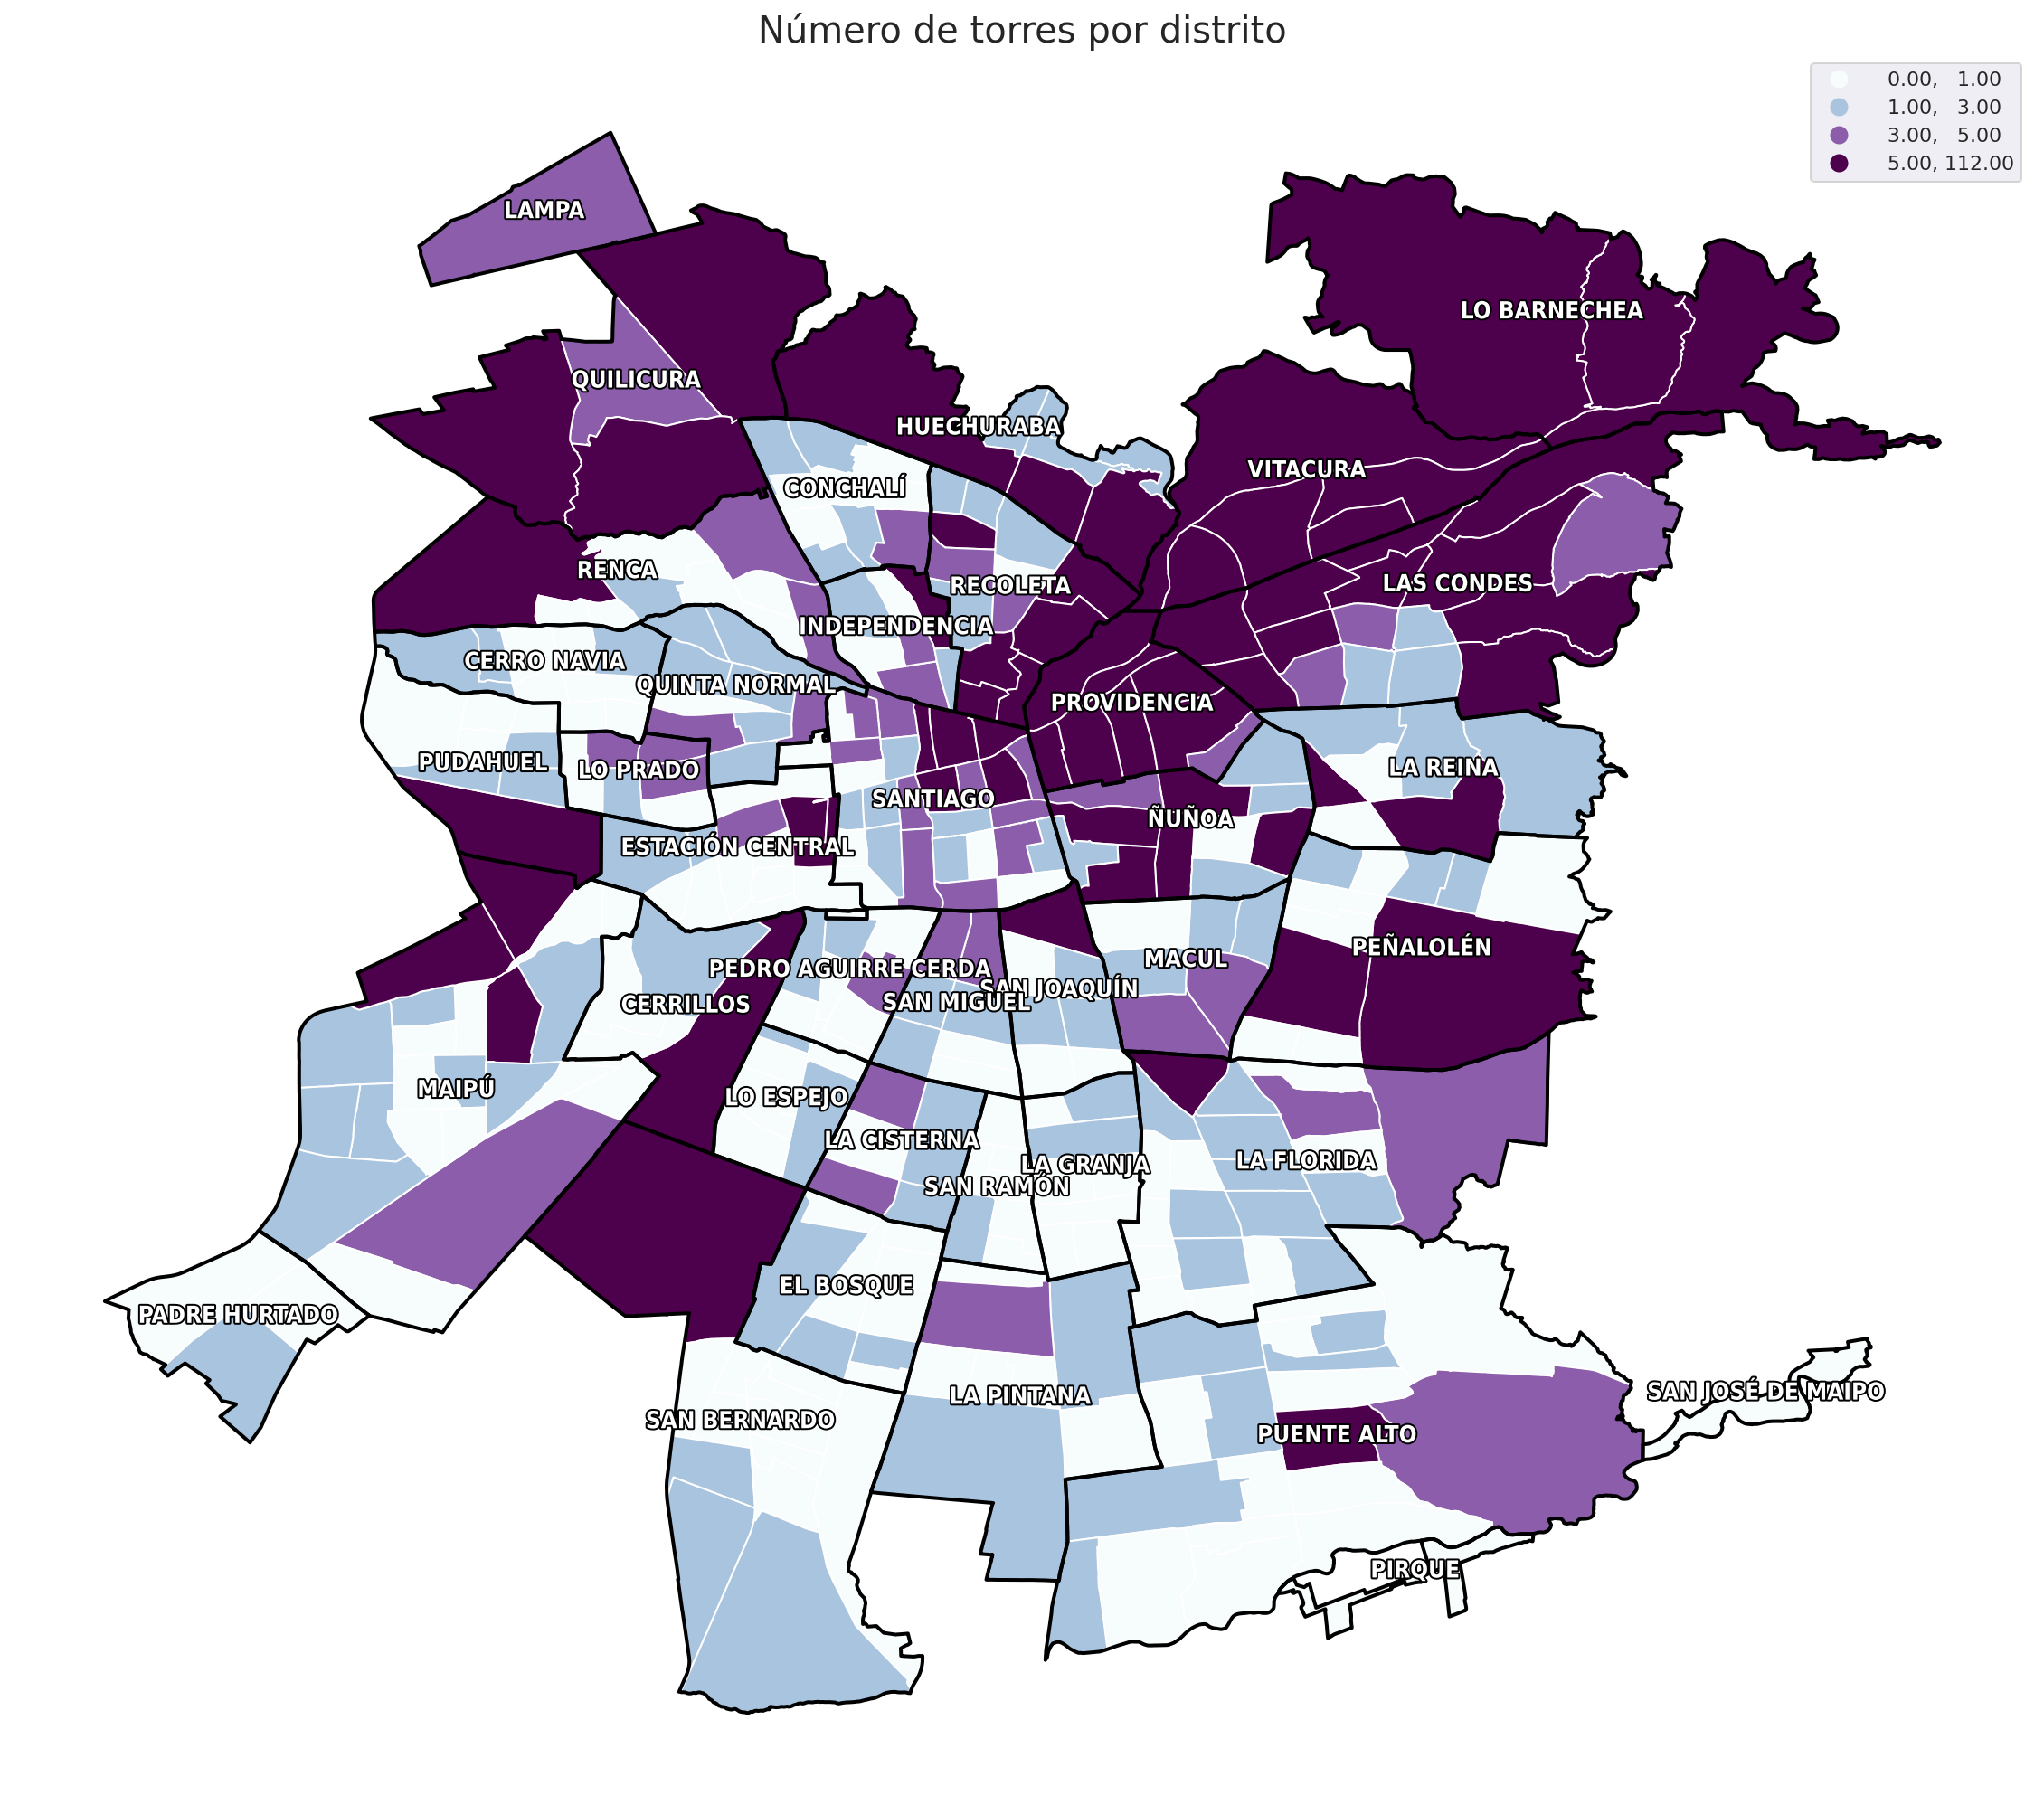

In [31]:
plot_distritos(data, column='Torres', title='Número de torres por distrito')
plt.savefig('/home/jsepulveda/images/torres_distritos.png', dpi=150, bbox_inches='tight');

# #############################################################

In [9]:
indexNames = urban_comunas[(urban_comunas['NOM_COMUNA'] != 'CERRILLOS') & (urban_comunas['NOM_COMUNA'] != 'PEDRO AGUIRRE CERDA') & (urban_comunas['NOM_COMUNA'] != 'SANTIAGO') & (urban_comunas['NOM_COMUNA'] != 'SAN MIGUEL') & (urban_comunas['NOM_COMUNA'] != 'SAN JOAQUÍN') & (urban_comunas['NOM_COMUNA'] != 'ÑUÑOA') & (urban_comunas['NOM_COMUNA'] != 'PROVIDENCIA')].index
urban_comunas.drop(indexNames, inplace=True)
urban_comunas.head()

REGION                        NOM_REGION  PROVINCIA NOM_PROVIN  COMUNA  \
8       13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13121   
21      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13102   
24      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13120   
32      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13129   
33      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13130   

             NOM_COMUNA  SHAPE_Leng  SHAPE_Area  \
8   PEDRO AGUIRRE CERDA    0.127968    0.000850   
21            CERRILLOS    0.204707    0.001628   
24                ÑUÑOA    0.177127    0.001635   
32          SAN JOAQUÍN    0.134525    0.000965   
33           SAN MIGUEL    0.128936    0.000933   

                                             geometry  
8   POLYGON ((-70.65563 -33.47835, -70.65571 -33.4...  
21  POLYGON ((-70.71265 -33.48103, -70.71249 -33.4...  
24  POLYGON ((-70.57808 -33.43609, -70.57799 -33.4...  
32  POLYGON ((-70.62322 -33.47457, -70.62321 -33.4...  
33  POLYGON ((-70.64197 -33.47650, -70.64191 -33.4...

### También los distritos...

In [10]:
indexNames = urban_distritos[(urban_distritos['NOM_COMUNA'] != 'CERRILLOS') & (urban_distritos['NOM_COMUNA'] != 'PEDRO AGUIRRE CERDA') & (urban_distritos['NOM_COMUNA'] != 'SANTIAGO') & (urban_distritos['NOM_COMUNA'] != 'SAN MIGUEL') & (urban_distritos['NOM_COMUNA'] != 'SAN JOAQUÍN') & (urban_distritos['NOM_COMUNA'] != 'ÑUÑOA') & (urban_distritos['NOM_COMUNA'] != 'PROVIDENCIA')].index
urban_distritos.drop(indexNames, inplace=True)
urban_distritos.head()

REGION                        NOM_REGION  PROVINCIA NOM_PROVIN  COMUNA  \
58      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13121   
59      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13121   
60      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13121   
61      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13121   
62      13  REGIÓN METROPOLITANA DE SANTIAGO        131   SANTIAGO   13121   

             NOM_COMUNA  COD_DISTRI TIPO_DISTR  SHAPE_Leng  SHAPE_Area  \
58  PEDRO AGUIRRE CERDA           2     URBANO    0.060496    0.000159   
59  PEDRO AGUIRRE CERDA           6     URBANO    0.055696    0.000136   
60  PEDRO AGUIRRE CERDA           1     URBANO    0.038523    0.000090   
61  PEDRO AGUIRRE CERDA           3     URBANO    0.049509    0.000134   
62  PEDRO AGUIRRE CERDA           5     URBANO    0.040292    0.000075   

                                             geometry  
58  POLYGON ((-70.65912 -33.48562, -70.65918 -33.4...  
59  POLYGON ((-70.68182 -33.47654, -70.68144 -33.4...  
60  POLYGON ((-70.67338 -33.48779, -70.67384 -33.4...  
61  POLYGON ((-70.66848 -33.48751, -70.66844 -33.4...  
62  POLYGON ((-70.67804 -33.49706, -70.67820 -33.4...

### Las Torres ...

In [11]:
indexNames = torres_gdf[(torres_gdf['NOM_COMUNA'] != 'CERRILLOS') & (torres_gdf['NOM_COMUNA'] != 'PEDRO AGUIRRE CERDA') & (torres_gdf['NOM_COMUNA'] != 'SANTIAGO') & (torres_gdf['NOM_COMUNA'] != 'SAN MIGUEL') & (torres_gdf['NOM_COMUNA'] != 'SAN JOAQUÍN') & (torres_gdf['NOM_COMUNA'] != 'ÑUÑOA') & (torres_gdf['NOM_COMUNA'] != 'PROVIDENCIA')].index
torres_gdf.drop(indexNames, inplace=True)
torres_gdf.head()

rinhead                     geometry   NOM_COMUNA
0   11SEP  POINT (-70.61111 -33.42227)  PROVIDENCIA
1   ALBER  POINT (-70.63374 -33.43539)  PROVIDENCIA
2   ATICF  POINT (-70.60563 -33.42468)  PROVIDENCIA
3   AVIUM  POINT (-70.62628 -33.44031)  PROVIDENCIA
4   BARRO  POINT (-70.61785 -33.43059)  PROVIDENCIA

### Y se utiliza sjoin para sacar los pois de educación correspondientes a esas comunas

In [12]:
urban_distritos = urban_distritos.set_crs("EPSG:4326")
comunas_l6_pois = gpd.sjoin(amenity_gdf,urban_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
comunas_l6_pois.head()

Unnamed: 0         id  changeset        lat   timestamp  \
0           1  133663460        0.0 -33.446224  1342745401   
1         243  436055942        0.0 -33.444020  1246942797   
2         355  479358198        0.0 -33.438670  1477501264   
3         357  479397637        0.0 -33.441260  1525966301   
4         365  484737375        0.0 -33.440254  1252165529   

                                  tags  version        lon addr:city  \
0  {"alt_name":"Ciudadano Restaurant"}        7 -70.628490       NaN   
1                                  NaN        1 -70.628784       NaN   
2                                  NaN        9 -70.632130       NaN   
3                                  NaN        9 -70.631226       NaN   
4                                  NaN        1 -70.632910       NaN   

  addr:country  ... REGION                        NOM_REGION PROVINCIA  \
0          NaN  ...     13  REGIÓN METROPOLITANA DE SANTIAGO       131   
1          NaN  ...     13  REGIÓN METROPOLITANA DE SANTIAGO       131   
2          NaN  ...     13  REGIÓN METROPOLITANA DE SANTIAGO       131   
3          NaN  ...     13  REGIÓN METROPOLITANA DE SANTIAGO       131   
4          NaN  ...     13  REGIÓN METROPOLITANA DE SANTIAGO       131   

  NOM_PROVIN COMUNA   NOM_COMUNA COD_DISTRI TIPO_DISTR SHAPE_Leng SHAPE_Area  
0   SANTIAGO  13123  PROVIDENCIA          6     URBANO   0.043244   0.000095  
1   SANTIAGO  13123  PROVIDENCIA          6     URBANO   0.043244   0.000095  
2   SANTIAGO  13123  PROVIDENCIA          6     URBANO   0.043244   0.000095  
3   SANTIAGO  13123  PROVIDENCIA          6     URBANO   0.043244   0.000095  
4   SANTIAGO  13123  PROVIDENCIA          6     URBANO   0.043244   0.000095  

[5 rows x 68 columns]

### Visualizamos nuevamente...

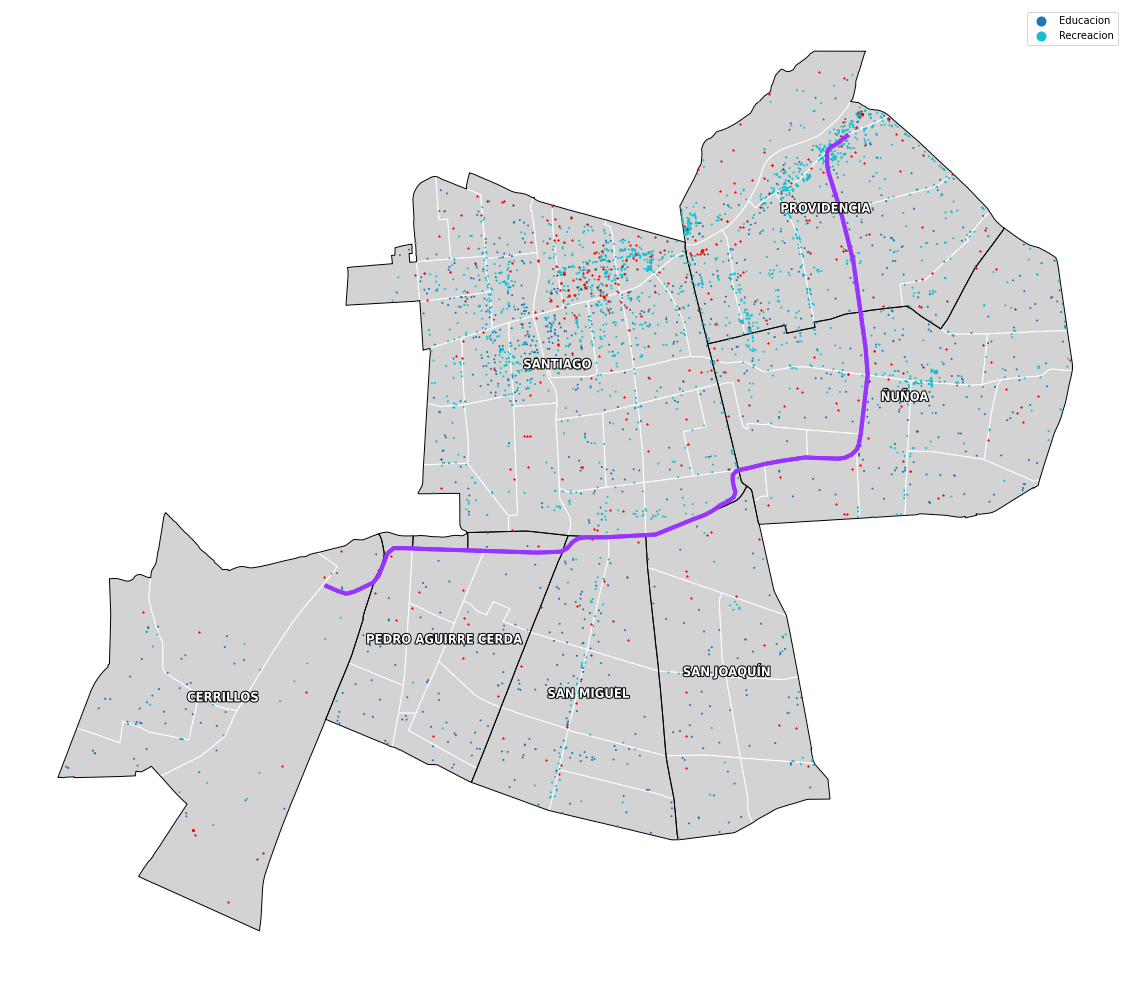

In [13]:
ax = urban_distritos.plot(figsize=(20,20),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = urban_comunas.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = comunas_l6_pois.plot(column='amenity', figsize=(20,20),markersize=1,legend=True,ax=ax)
ax = torres_gdf.plot(marker='*', color='red',markersize=2,ax=ax)
ax = ruta_gdf.plot(color='#'+ ruta_gdf.route_color,linewidth=4,ax=ax)


texts = []
for comuna, centroid in zip(urban_comunas['NOM_COMUNA'], urban_comunas.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

### Ahora podemos hacer analisis de densidades de pois o antenas por comuna y distrito

## Cerrillos

<ipython-input-59-59c0ddc83bdf>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for distrito, centroid in zip(cerrillos_distritos['COD_DISTRI'], cerrillos_distritos.centroid):


Text(0.5, 1.0, 'Cantidad de POIs Recreación por Distrito')

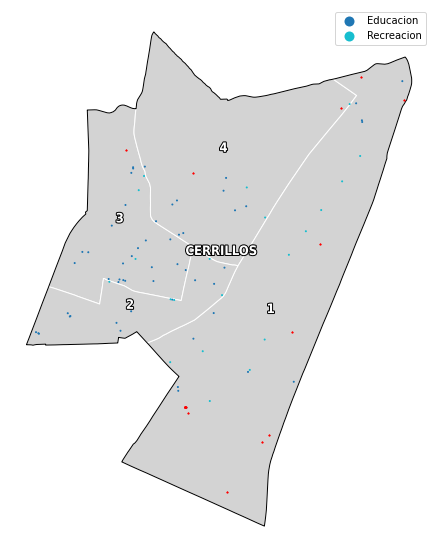

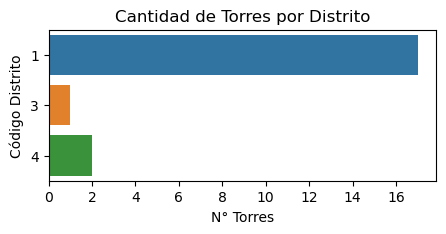

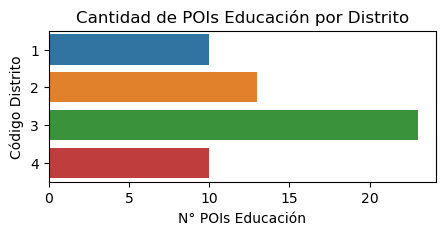

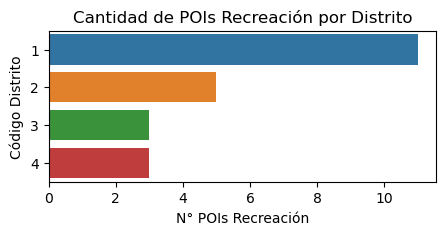

In [59]:
#Comuna
cerrillos = urban_comunas.copy()
indexNames = cerrillos[(cerrillos['NOM_COMUNA'] != 'CERRILLOS')].index
cerrillos.drop(indexNames, inplace =True)

#Distritos
cerrillos_distritos = urban_distritos.copy()
indexNames = cerrillos_distritos[(cerrillos_distritos['NOM_COMUNA'] != 'CERRILLOS')].index
cerrillos_distritos.drop(indexNames, inplace =True)

#Antenas
cerrillos_torres = torres_gdf.copy()
indexNames = cerrillos_torres[(cerrillos_torres['NOM_COMUNA'] != 'CERRILLOS')].index
cerrillos_torres.drop(indexNames, inplace =True)

#Pois
cerrillos_pois = comunas_l6_pois.copy()
indexNames = cerrillos_pois[(cerrillos_pois['NOM_COMUNA'] != 'CERRILLOS')].index
cerrillos_pois.drop(indexNames, inplace =True)

#Visualizacion
ax = cerrillos_distritos.plot(figsize=(10,10),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = cerrillos.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = cerrillos_pois.plot(column='amenity', figsize=(10,10),markersize=1,legend=True,ax=ax)
ax = cerrillos_torres.plot(marker='*', color='red',markersize=2,ax=ax)


texts = []
for comuna, centroid in zip(cerrillos['NOM_COMUNA'], cerrillos.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)

texts = []
for distrito, centroid in zip(cerrillos_distritos['COD_DISTRI'], cerrillos_distritos.centroid):
    t = ax.text(centroid.x, centroid.y, distrito, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');
####################################################
fig = plt.figure(dpi=100, figsize=(5,2))

cerrillos_distritos = cerrillos_distritos.set_crs("EPSG:4326")
cerrillos_torres_distrito = gpd.sjoin(cerrillos_torres,cerrillos_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = cerrillos_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()

ax1 = fig.gca()
sns.barplot(x=torres_por_distrito.rinhead, y=torres_por_distrito.COD_DISTRI, ax=ax1, orient="h")
ax1.set_ylabel("Código Distrito")
ax1.set_xlabel("N° Torres")
ax1.set_title("Cantidad de Torres por Distrito")
###################################################
fig2 = plt.figure(dpi=100, figsize=(5,2))

cerrillos_educacion = cerrillos_pois.copy()
indexNames = cerrillos_educacion[(cerrillos_educacion['amenity'] != 'Educacion')].index
cerrillos_educacion.drop(indexNames, inplace = True)
cerrillos_educacion_pois = cerrillos_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 

ax2 = fig2.gca()
sns.barplot(x=cerrillos_educacion_pois.amenity, y=cerrillos_educacion_pois.COD_DISTRI, ax=ax2, orient="h")
ax2.set_ylabel("Código Distrito")
ax2.set_xlabel("N° POIs Educación")
ax2.set_title("Cantidad de POIs Educación por Distrito")

##################################################
fig3 = plt.figure(dpi=100, figsize=(5,2))

cerrillos_recreacion = cerrillos_pois.copy()
indexNames = cerrillos_recreacion[(cerrillos_recreacion['amenity'] != 'Recreacion')].index
cerrillos_recreacion.drop(indexNames, inplace = True)
cerrillos_recreacion_pois = cerrillos_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()

ax3 = fig3.gca()
sns.barplot(x=cerrillos_recreacion_pois.amenity, y=cerrillos_recreacion_pois.COD_DISTRI, ax=ax3, orient="h")
ax3.set_ylabel("Código Distrito")
ax3.set_xlabel("N° POIs Recreación")
ax3.set_title("Cantidad de POIs Recreación por Distrito")



### Torres y Pois por distrito

In [55]:
cerrillos_distritos = cerrillos_distritos.set_crs("EPSG:4326")
cerrillos_torres_distrito = gpd.sjoin(cerrillos_torres,cerrillos_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = cerrillos_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()
torres_por_distrito.rename(columns={'rinhead':'Torres', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
torres_por_distrito.head()


Código Distrito  Torres
0                1      17
1                3       1
2                4       2

In [56]:
cerrillos_educacion = cerrillos_pois.copy()
indexNames = cerrillos_educacion[(cerrillos_educacion['amenity'] != 'Educacion')].index
cerrillos_educacion.drop(indexNames, inplace = True)
cerrillos_educacion_pois = cerrillos_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 
cerrillos_educacion_pois.rename(columns={'amenity':'POIs Educacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
cerrillos_educacion_pois.head()

Código Distrito  POIs Educacion
0                1              10
1                2              13
2                3              23
3                4              10

In [17]:
cerrillos_recreacion = cerrillos_pois.copy()
indexNames = cerrillos_recreacion[(cerrillos_recreacion['amenity'] != 'Recreacion')].index
cerrillos_recreacion.drop(indexNames, inplace = True)
cerrillos_recreacion_pois = cerrillos_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()
cerrillos_recreacion_pois.rename(columns={'amenity':'POIs Recreacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
cerrillos_recreacion_pois.head()

Código Distrito  POIs Recreacion
0                1               11
1                2                5
2                3                3
3                4                3

## Pedro Aguirre Cerda

<ipython-input-60-addae2f76c1c>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for distrito, centroid in zip(pac_distritos['COD_DISTRI'], pac_distritos.centroid):


Text(0.5, 1.0, 'Cantidad de POIs Recreación por Distrito')

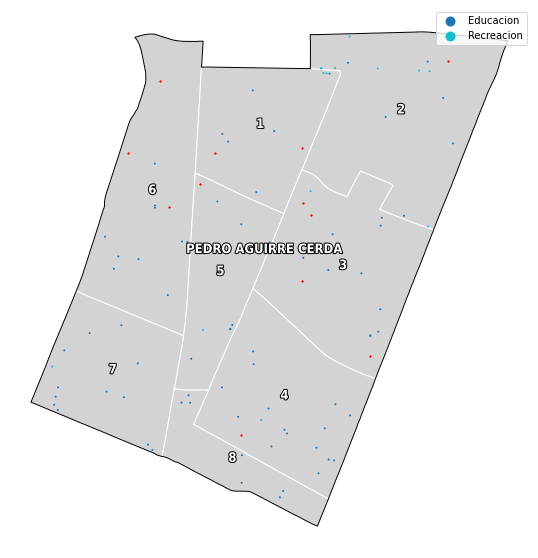

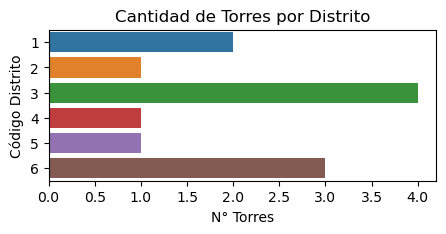

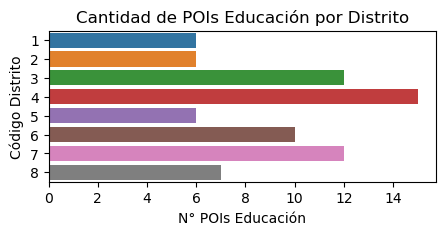

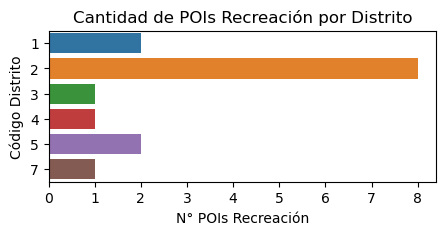

In [60]:
#Comuna
pac = urban_comunas.copy()
indexNames = pac[(pac['NOM_COMUNA'] != 'PEDRO AGUIRRE CERDA')].index
pac.drop(indexNames, inplace =True)

#Distritos
pac_distritos = urban_distritos.copy()
indexNames = pac_distritos[(pac_distritos['NOM_COMUNA'] != 'PEDRO AGUIRRE CERDA')].index
pac_distritos.drop(indexNames, inplace =True)

#Antenas
pac_torres = torres_gdf.copy()
indexNames = pac_torres[(pac_torres['NOM_COMUNA'] != 'PEDRO AGUIRRE CERDA')].index
pac_torres.drop(indexNames, inplace =True)

#Pois
pac_pois = comunas_l6_pois.copy()
indexNames = pac_pois[(pac_pois['NOM_COMUNA'] != 'PEDRO AGUIRRE CERDA')].index
pac_pois.drop(indexNames, inplace =True)

#Visualizacion
ax = pac_distritos.plot(figsize=(10,10),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = pac.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = pac_pois.plot(column='amenity', figsize=(10,10),markersize=1,legend=True,ax=ax)
ax = pac_torres.plot(marker='*', color='red',markersize=2,ax=ax)


texts = []
for comuna, centroid in zip(pac['NOM_COMUNA'], pac.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)

texts = []
for distrito, centroid in zip(pac_distritos['COD_DISTRI'], pac_distritos.centroid):
    t = ax.text(centroid.x, centroid.y, distrito, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

####################################################
fig = plt.figure(dpi=100, figsize=(5,2))

pac_distritos = pac_distritos.set_crs("EPSG:4326")
pac_torres_distrito = gpd.sjoin(pac_torres,pac_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = pac_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()

ax1 = fig.gca()
sns.barplot(x=torres_por_distrito.rinhead, y=torres_por_distrito.COD_DISTRI, ax=ax1, orient="h")
ax1.set_ylabel("Código Distrito")
ax1.set_xlabel("N° Torres")
ax1.set_title("Cantidad de Torres por Distrito")
###################################################
fig2 = plt.figure(dpi=100, figsize=(5,2))

pac_educacion = pac_pois.copy()
indexNames = pac_educacion[(pac_educacion['amenity'] != 'Educacion')].index
pac_educacion.drop(indexNames, inplace = True)
pac_educacion_pois = pac_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 

ax2 = fig2.gca()
sns.barplot(x=pac_educacion_pois.amenity, y=pac_educacion_pois.COD_DISTRI, ax=ax2, orient="h")
ax2.set_ylabel("Código Distrito")
ax2.set_xlabel("N° POIs Educación")
ax2.set_title("Cantidad de POIs Educación por Distrito")

##################################################
fig3 = plt.figure(dpi=100, figsize=(5,2))

pac_recreacion = pac_pois.copy()
indexNames = pac_recreacion[(pac_recreacion['amenity'] != 'Recreacion')].index
pac_recreacion.drop(indexNames, inplace = True)
pac_recreacion_pois = pac_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()

ax3 = fig3.gca()
sns.barplot(x=pac_recreacion_pois.amenity, y=pac_recreacion_pois.COD_DISTRI, ax=ax3, orient="h")
ax3.set_ylabel("Código Distrito")
ax3.set_xlabel("N° POIs Recreación")
ax3.set_title("Cantidad de POIs Recreación por Distrito")



### Torres y Pois por distrito

In [19]:
pac_distritos = pac_distritos.set_crs("EPSG:4326")
pac_torres_distrito = gpd.sjoin(pac_torres,pac_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = pac_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()
torres_por_distrito.rename(columns={'rinhead':'Torres', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(torres_por_distrito)

   Código Distrito  Torres
0                1       2
1                2       1
2                3       4
3                4       1
4                5       1
5                6       3


In [20]:
pac_educacion = pac_pois.copy()
indexNames = pac_educacion[(pac_educacion['amenity'] != 'Educacion')].index
pac_educacion.drop(indexNames, inplace = True)
pac_educacion_pois = pac_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 
pac_educacion_pois.rename(columns={'amenity':'POIs Educacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(pac_educacion_pois)

   Código Distrito  POIs Educacion
0                1               6
1                2               6
2                3              12
3                4              15
4                5               6
5                6              10
6                7              12
7                8               7


In [21]:
pac_recreacion = pac_pois.copy()
indexNames = pac_recreacion[(pac_recreacion['amenity'] != 'Recreacion')].index
pac_recreacion.drop(indexNames, inplace = True)
pac_recreacion_pois = pac_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()
pac_recreacion_pois.rename(columns={'amenity':'POIs Recreacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(pac_recreacion_pois)

   Código Distrito  POIs Recreacion
0                1                2
1                2                8
2                3                1
3                4                1
4                5                2
5                7                1


## San Miguel

<ipython-input-61-1e02711428fc>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for distrito, centroid in zip(sm_distritos['COD_DISTRI'], sm_distritos.centroid):


Text(0.5, 1.0, 'Cantidad de POIs Recreación por Distrito')

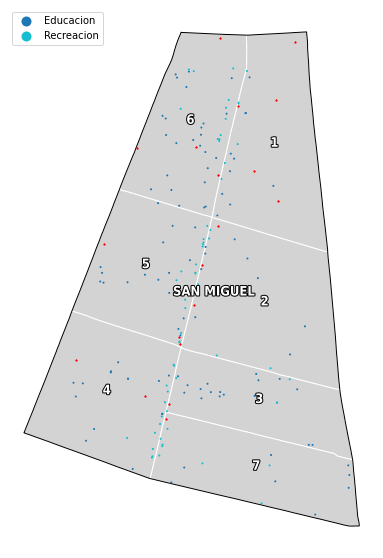

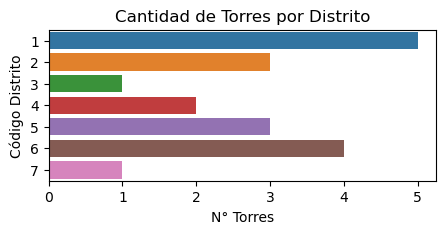

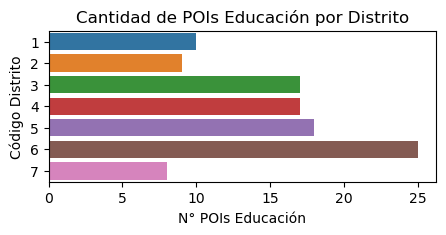

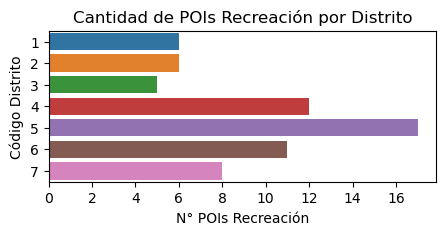

In [61]:
#Comuna
sm = urban_comunas.copy()
indexNames = sm[(sm['NOM_COMUNA'] != 'SAN MIGUEL')].index
sm.drop(indexNames, inplace =True)

#Distritos
sm_distritos = urban_distritos.copy()
indexNames = sm_distritos[(sm_distritos['NOM_COMUNA'] != 'SAN MIGUEL')].index
sm_distritos.drop(indexNames, inplace =True)

#Antenas
sm_torres = torres_gdf.copy()
indexNames = sm_torres[(sm_torres['NOM_COMUNA'] != 'SAN MIGUEL')].index
sm_torres.drop(indexNames, inplace =True)

#Pois
sm_pois = comunas_l6_pois.copy()
indexNames = sm_pois[(sm_pois['NOM_COMUNA'] != 'SAN MIGUEL')].index
sm_pois.drop(indexNames, inplace =True)

#Visualizacion
ax = sm_distritos.plot(figsize=(10,10),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = sm.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = sm_pois.plot(column='amenity', figsize=(10,10),markersize=1,legend=True,ax=ax)
ax = sm_torres.plot(marker='*', color='red',markersize=2,ax=ax)


texts = []
for comuna, centroid in zip(sm['NOM_COMUNA'], sm.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)

texts = []
for distrito, centroid in zip(sm_distritos['COD_DISTRI'], sm_distritos.centroid):
    t = ax.text(centroid.x, centroid.y, distrito, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

####################################################
fig = plt.figure(dpi=100, figsize=(5,2))

sm_distritos = sm_distritos.set_crs("EPSG:4326")
sm_torres_distrito = gpd.sjoin(sm_torres,sm_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = sm_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()

ax1 = fig.gca()
sns.barplot(x=torres_por_distrito.rinhead, y=torres_por_distrito.COD_DISTRI, ax=ax1, orient="h")
ax1.set_ylabel("Código Distrito")
ax1.set_xlabel("N° Torres")
ax1.set_title("Cantidad de Torres por Distrito")
###################################################
fig2 = plt.figure(dpi=100, figsize=(5,2))

sm_educacion = sm_pois.copy()
indexNames = sm_educacion[(sm_educacion['amenity'] != 'Educacion')].index
sm_educacion.drop(indexNames, inplace = True)
sm_educacion_pois = sm_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 

ax2 = fig2.gca()
sns.barplot(x=sm_educacion_pois.amenity, y=sm_educacion_pois.COD_DISTRI, ax=ax2, orient="h")
ax2.set_ylabel("Código Distrito")
ax2.set_xlabel("N° POIs Educación")
ax2.set_title("Cantidad de POIs Educación por Distrito")

##################################################
fig3 = plt.figure(dpi=100, figsize=(5,2))

sm_recreacion = sm_pois.copy()
indexNames = sm_recreacion[(sm_recreacion['amenity'] != 'Recreacion')].index
sm_recreacion.drop(indexNames, inplace = True)
sm_recreacion_pois = sm_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()

ax3 = fig3.gca()
sns.barplot(x=sm_recreacion_pois.amenity, y=sm_recreacion_pois.COD_DISTRI, ax=ax3, orient="h")
ax3.set_ylabel("Código Distrito")
ax3.set_xlabel("N° POIs Recreación")
ax3.set_title("Cantidad de POIs Recreación por Distrito")



### Torres y Pois por distrito


In [23]:
sm_distritos = sm_distritos.set_crs("EPSG:4326")
sm_torres_distrito = gpd.sjoin(sm_torres,sm_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = sm_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()
torres_por_distrito.rename(columns={'rinhead':'Torres', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(torres_por_distrito)

   Código Distrito  Torres
0                1       5
1                2       3
2                3       1
3                4       2
4                5       3
5                6       4
6                7       1


In [24]:
sm_educacion = sm_pois.copy()
indexNames = sm_educacion[(sm_educacion['amenity'] != 'Educacion')].index
sm_educacion.drop(indexNames, inplace = True)
sm_educacion_pois = sm_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 
sm_educacion_pois.rename(columns={'amenity':'POIs Educacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(sm_educacion_pois)

   Código Distrito  POIs Educacion
0                1              10
1                2               9
2                3              17
3                4              17
4                5              18
5                6              25
6                7               8


In [25]:
sm_recreacion = sm_pois.copy()
indexNames = sm_recreacion[(sm_recreacion['amenity'] != 'Recreacion')].index
sm_recreacion.drop(indexNames, inplace = True)
sm_recreacion_pois = sm_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()
sm_recreacion_pois.rename(columns={'amenity':'POIs Recreacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(sm_recreacion_pois)

   Código Distrito  POIs Recreacion
0                1                6
1                2                6
2                3                5
3                4               12
4                5               17
5                6               11
6                7                8


## San Joaquin

<ipython-input-62-8dc1fdac55c7>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for distrito, centroid in zip(sj_distritos['COD_DISTRI'], sj_distritos.centroid):


Text(0.5, 1.0, 'Cantidad de POIs Recreación por Distrito')

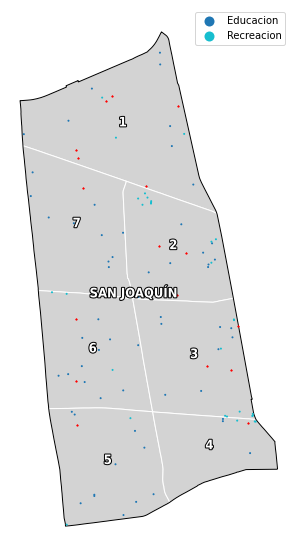

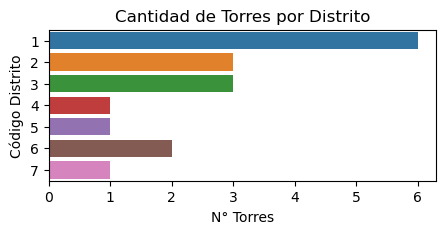

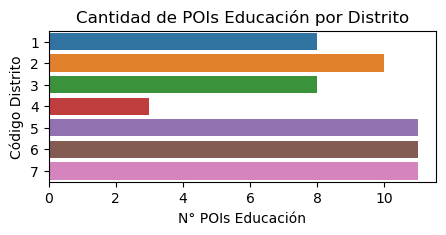

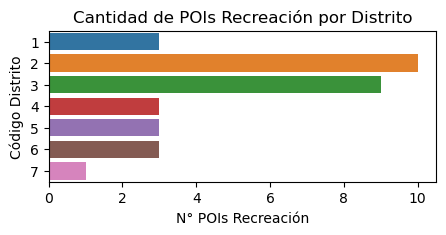

In [62]:
#Comuna
sj = urban_comunas.copy()
indexNames = sj[(sj['NOM_COMUNA'] != 'SAN JOAQUÍN')].index
sj.drop(indexNames, inplace =True)

#Distritos
sj_distritos = urban_distritos.copy()
indexNames = sj_distritos[(sj_distritos['NOM_COMUNA'] != 'SAN JOAQUÍN')].index
sj_distritos.drop(indexNames, inplace =True)

#Antenas
sj_torres = torres_gdf.copy()
indexNames = sj_torres[(sj_torres['NOM_COMUNA'] != 'SAN JOAQUÍN')].index
sj_torres.drop(indexNames, inplace =True)

#Pois
sj_pois = comunas_l6_pois.copy()
indexNames = sj_pois[(sj_pois['NOM_COMUNA'] != 'SAN JOAQUÍN')].index
sj_pois.drop(indexNames, inplace =True)

#Visualizacion
ax = sj_distritos.plot(figsize=(10,10),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = sj.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = sj_pois.plot(column='amenity', figsize=(10,10),markersize=1,legend=True,ax=ax)
ax = sj_torres.plot(marker='*', color='red',markersize=2,ax=ax)


texts = []
for comuna, centroid in zip(sj['NOM_COMUNA'], sj.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)

texts = []
for distrito, centroid in zip(sj_distritos['COD_DISTRI'], sj_distritos.centroid):
    t = ax.text(centroid.x, centroid.y, distrito, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

####################################################
fig = plt.figure(dpi=100, figsize=(5,2))

sj_distritos = sj_distritos.set_crs("EPSG:4326")
sj_torres_distrito = gpd.sjoin(sj_torres,sj_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = sj_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()

ax1 = fig.gca()
sns.barplot(x=torres_por_distrito.rinhead, y=torres_por_distrito.COD_DISTRI, ax=ax1, orient="h")
ax1.set_ylabel("Código Distrito")
ax1.set_xlabel("N° Torres")
ax1.set_title("Cantidad de Torres por Distrito")
###################################################
fig2 = plt.figure(dpi=100, figsize=(5,2))

sj_educacion = sj_pois.copy()
indexNames = sj_educacion[(sj_educacion['amenity'] != 'Educacion')].index
sj_educacion.drop(indexNames, inplace = True)
sj_educacion_pois = sj_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 

ax2 = fig2.gca()
sns.barplot(x=sj_educacion_pois.amenity, y=sj_educacion_pois.COD_DISTRI, ax=ax2, orient="h")
ax2.set_ylabel("Código Distrito")
ax2.set_xlabel("N° POIs Educación")
ax2.set_title("Cantidad de POIs Educación por Distrito")

##################################################
fig3 = plt.figure(dpi=100, figsize=(5,2))

sj_recreacion = sj_pois.copy()
indexNames = sj_recreacion[(sj_recreacion['amenity'] != 'Recreacion')].index
sj_recreacion.drop(indexNames, inplace = True)
sj_recreacion_pois = sj_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()

ax3 = fig3.gca()
sns.barplot(x=sj_recreacion_pois.amenity, y=sj_recreacion_pois.COD_DISTRI, ax=ax3, orient="h")
ax3.set_ylabel("Código Distrito")
ax3.set_xlabel("N° POIs Recreación")
ax3.set_title("Cantidad de POIs Recreación por Distrito")



### Torres y Pois por distrito

In [27]:
sj_distritos = sj_distritos.set_crs("EPSG:4326")
sj_torres_distrito = gpd.sjoin(sj_torres,sj_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = sj_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()
torres_por_distrito.rename(columns={'rinhead':'Torres', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(torres_por_distrito)

   Código Distrito  Torres
0                1       6
1                2       3
2                3       3
3                4       1
4                5       1
5                6       2
6                7       1


In [28]:
sj_educacion = sj_pois.copy()
indexNames = sj_educacion[(sj_educacion['amenity'] != 'Educacion')].index
sj_educacion.drop(indexNames, inplace = True)
sj_educacion_pois = sj_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 
sj_educacion_pois.rename(columns={'amenity':'POIs Educacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(sj_educacion_pois)

   Código Distrito  POIs Educacion
0                1               8
1                2              10
2                3               8
3                4               3
4                5              11
5                6              11
6                7              11


In [29]:
sj_recreacion = sj_pois.copy()
indexNames = sj_recreacion[(sj_recreacion['amenity'] != 'Recreacion')].index
sj_recreacion.drop(indexNames, inplace = True)
sj_recreacion_pois = sj_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()
sj_recreacion_pois.rename(columns={'amenity':'POIs Recreacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(sj_recreacion_pois)

   Código Distrito  POIs Recreacion
0                1                3
1                2               10
2                3                9
3                4                3
4                5                3
5                6                3
6                7                1


## Santiago

<ipython-input-64-54a7da4334a6>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for distrito, centroid in zip(scl_distritos['COD_DISTRI'], scl_distritos.centroid):


Text(0.5, 1.0, 'Cantidad de POIs Recreación por Distrito')

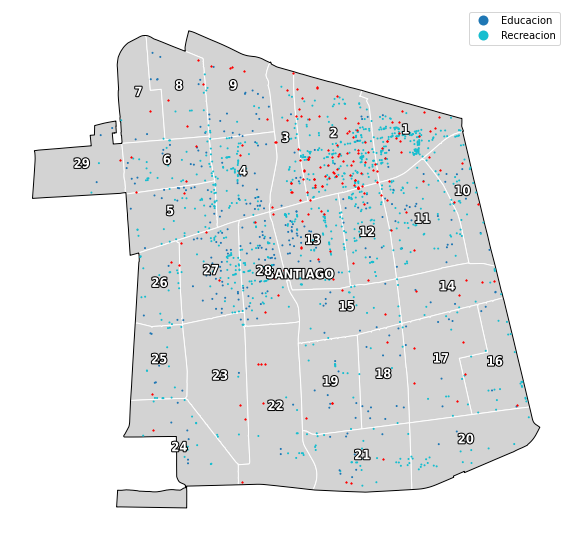

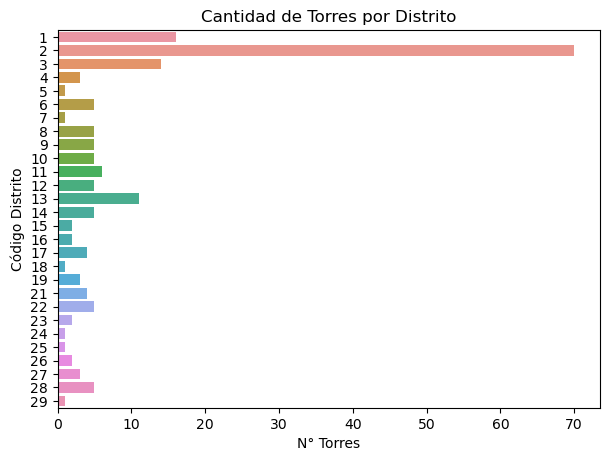

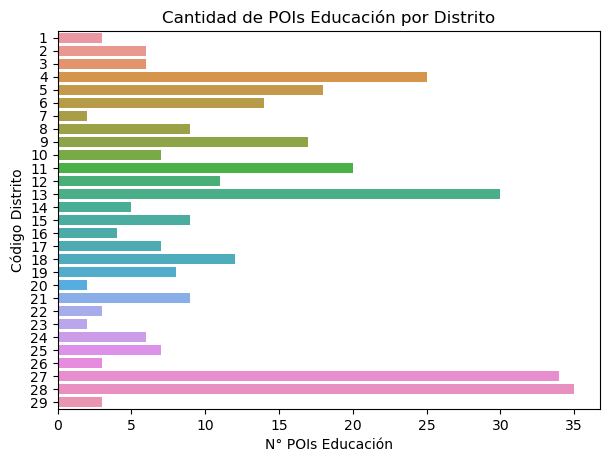

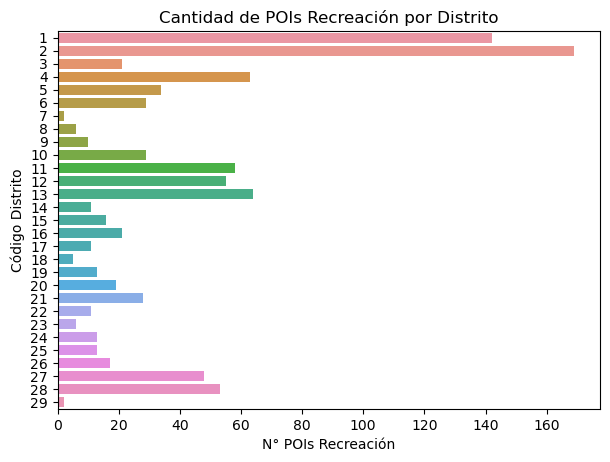

In [64]:
#Comuna
scl = urban_comunas.copy()
indexNames = scl[(scl['NOM_COMUNA'] != 'SANTIAGO')].index
scl.drop(indexNames, inplace =True)

#Distritos
scl_distritos = urban_distritos.copy()
indexNames = scl_distritos[(scl_distritos['NOM_COMUNA'] != 'SANTIAGO')].index
scl_distritos.drop(indexNames, inplace =True)

#Antenas
scl_torres = torres_gdf.copy()
indexNames = scl_torres[(scl_torres['NOM_COMUNA'] != 'SANTIAGO')].index
scl_torres.drop(indexNames, inplace =True)

#Pois
scl_pois = comunas_l6_pois.copy()
indexNames = scl_pois[(scl_pois['NOM_COMUNA'] != 'SANTIAGO')].index
scl_pois.drop(indexNames, inplace =True)

#Visualizacion
ax = scl_distritos.plot(figsize=(10,10),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = scl.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = scl_pois.plot(column='amenity', figsize=(10,10),markersize=1,legend=True,ax=ax)
ax = scl_torres.plot(marker='*', color='red',markersize=2,ax=ax)


texts = []
for comuna, centroid in zip(scl['NOM_COMUNA'], scl.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)

texts = []
for distrito, centroid in zip(scl_distritos['COD_DISTRI'], scl_distritos.centroid):
    t = ax.text(centroid.x, centroid.y, distrito, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');
####################################################
fig = plt.figure(dpi=100, figsize=(7,5))

scl_distritos = scl_distritos.set_crs("EPSG:4326")
scl_torres_distrito = gpd.sjoin(scl_torres,scl_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = scl_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()

ax1 = fig.gca()
sns.barplot(x=torres_por_distrito.rinhead, y=torres_por_distrito.COD_DISTRI, ax=ax1, orient="h")
ax1.set_ylabel("Código Distrito")
ax1.set_xlabel("N° Torres")
ax1.set_title("Cantidad de Torres por Distrito")
###################################################
fig2 = plt.figure(dpi=100, figsize=(7,5))

scl_educacion = scl_pois.copy()
indexNames = scl_educacion[(scl_educacion['amenity'] != 'Educacion')].index
scl_educacion.drop(indexNames, inplace = True)
scl_educacion_pois = scl_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 

ax2 = fig2.gca()
sns.barplot(x=scl_educacion_pois.amenity, y=scl_educacion_pois.COD_DISTRI, ax=ax2, orient="h")
ax2.set_ylabel("Código Distrito")
ax2.set_xlabel("N° POIs Educación")
ax2.set_title("Cantidad de POIs Educación por Distrito")

##################################################
fig3 = plt.figure(dpi=100, figsize=(7,5))

scl_recreacion = scl_pois.copy()
indexNames = scl_recreacion[(scl_recreacion['amenity'] != 'Recreacion')].index
scl_recreacion.drop(indexNames, inplace = True)
scl_recreacion_pois = scl_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()

ax3 = fig3.gca()
sns.barplot(x=scl_recreacion_pois.amenity, y=scl_recreacion_pois.COD_DISTRI, ax=ax3, orient="h")
ax3.set_ylabel("Código Distrito")
ax3.set_xlabel("N° POIs Recreación")
ax3.set_title("Cantidad de POIs Recreación por Distrito")

### Torres y Pois por distrito

In [31]:
scl_distritos = scl_distritos.set_crs("EPSG:4326")
scl_torres_distrito = gpd.sjoin(scl_torres,scl_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = scl_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()
torres_por_distrito.rename(columns={'rinhead':'Torres', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(torres_por_distrito)

    Código Distrito  Torres
0                 1      16
1                 2      70
2                 3      14
3                 4       3
4                 5       1
5                 6       5
6                 7       1
7                 8       5
8                 9       5
9                10       5
10               11       6
11               12       5
12               13      11
13               14       5
14               15       2
15               16       2
16               17       4
17               18       1
18               19       3
19               21       4
20               22       5
21               23       2
22               24       1
23               25       1
24               26       2
25               27       3
26               28       5
27               29       1


In [53]:
scl_educacion = scl_pois.copy()
indexNames = scl_educacion[(scl_educacion['amenity'] != 'Educacion')].index
scl_educacion.drop(indexNames, inplace = True)
scl_educacion_pois = scl_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 
scl_educacion_pois.rename(columns={'amenity':'POIs Educacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(scl_educacion_pois)

    Código Distrito  POIs Educacion
0                 1               3
1                 2               6
2                 3               6
3                 4              25
4                 5              18
5                 6              14
6                 7               2
7                 8               9
8                 9              17
9                10               7
10               11              20
11               12              11
12               13              30
13               14               5
14               15               9
15               16               4
16               17               7
17               18              12
18               19               8
19               20               2
20               21               9
21               22               3
22               23               2
23               24               6
24               25               7
25               26               3
26               27         

In [32]:
scl_recreacion = scl_pois.copy()
indexNames = scl_recreacion[(scl_recreacion['amenity'] != 'Recreacion')].index
scl_recreacion.drop(indexNames, inplace = True)
scl_recreacion_pois = scl_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()
scl_recreacion_pois.rename(columns={'amenity':'POIs Recreacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(scl_recreacion_pois)

    Código Distrito  POIs Recreacion
0                 1              142
1                 2              169
2                 3               21
3                 4               63
4                 5               34
5                 6               29
6                 7                2
7                 8                6
8                 9               10
9                10               29
10               11               58
11               12               55
12               13               64
13               14               11
14               15               16
15               16               21
16               17               11
17               18                5
18               19               13
19               20               19
20               21               28
21               22               11
22               23                6
23               24               13
24               25               13
25               26               17
2

## Ñuñoa

<ipython-input-66-709ebc84e679>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for distrito, centroid in zip(ñuñoa_distritos['COD_DISTRI'], ñuñoa_distritos.centroid):


Text(0.5, 1.0, 'Cantidad de POIs Recreación por Distrito')

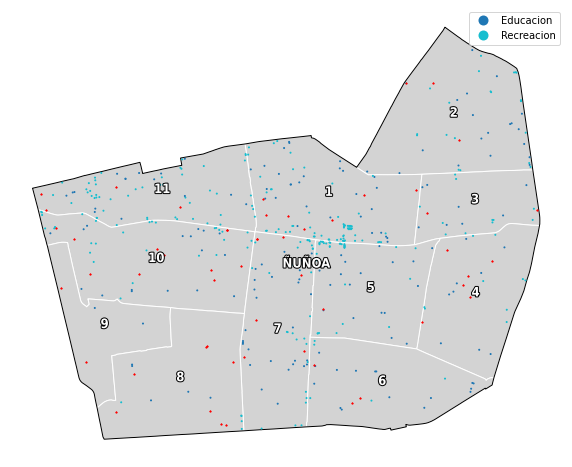

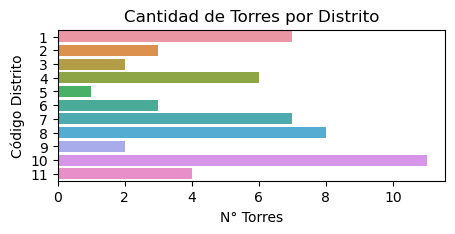

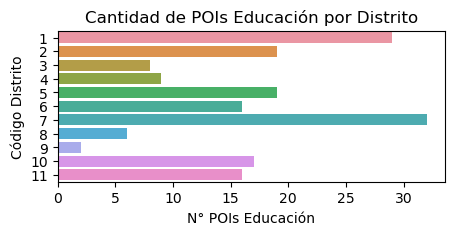

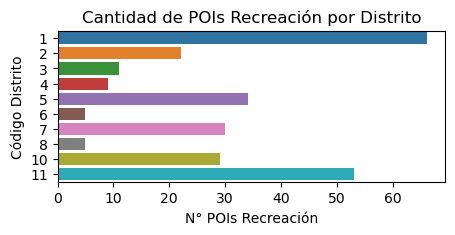

In [66]:
#Comuna
ñuñoa = urban_comunas.copy()
indexNames = ñuñoa[(ñuñoa['NOM_COMUNA'] != 'ÑUÑOA')].index
ñuñoa.drop(indexNames, inplace =True)

#Distritos
ñuñoa_distritos = urban_distritos.copy()
indexNames = ñuñoa_distritos[(ñuñoa_distritos['NOM_COMUNA'] != 'ÑUÑOA')].index
ñuñoa_distritos.drop(indexNames, inplace =True)

#Antenas
ñuñoa_torres = torres_gdf.copy()
indexNames = ñuñoa_torres[(ñuñoa_torres['NOM_COMUNA'] != 'ÑUÑOA')].index
ñuñoa_torres.drop(indexNames, inplace =True)

#Pois
ñuñoa_pois = comunas_l6_pois.copy()
indexNames = ñuñoa_pois[(ñuñoa_pois['NOM_COMUNA'] != 'ÑUÑOA')].index
ñuñoa_pois.drop(indexNames, inplace =True)

#Visualizacion
ax = ñuñoa_distritos.plot(figsize=(10,10),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = ñuñoa.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = ñuñoa_pois.plot(column='amenity', figsize=(10,10),markersize=1,legend=True,ax=ax)
ax = ñuñoa_torres.plot(marker='*', color='red',markersize=2,ax=ax)


texts = []
for comuna, centroid in zip(ñuñoa['NOM_COMUNA'], ñuñoa.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)

texts = []
for distrito, centroid in zip(ñuñoa_distritos['COD_DISTRI'], ñuñoa_distritos.centroid):
    t = ax.text(centroid.x, centroid.y, distrito, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');
####################################################
fig = plt.figure(dpi=100, figsize=(5,2))

ñuñoa_distritos = ñuñoa_distritos.set_crs("EPSG:4326")
ñuñoa_torres_distrito = gpd.sjoin(ñuñoa_torres,ñuñoa_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = ñuñoa_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()

ax1 = fig.gca()
sns.barplot(x=torres_por_distrito.rinhead, y=torres_por_distrito.COD_DISTRI, ax=ax1, orient="h")
ax1.set_ylabel("Código Distrito")
ax1.set_xlabel("N° Torres")
ax1.set_title("Cantidad de Torres por Distrito")
###################################################
fig2 = plt.figure(dpi=100, figsize=(5,2))

ñuñoa_educacion = ñuñoa_pois.copy()
indexNames = ñuñoa_educacion[(ñuñoa_educacion['amenity'] != 'Educacion')].index
ñuñoa_educacion.drop(indexNames, inplace = True)
ñuñoa_educacion_pois = ñuñoa_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 

ax2 = fig2.gca()
sns.barplot(x=ñuñoa_educacion_pois.amenity, y=ñuñoa_educacion_pois.COD_DISTRI, ax=ax2, orient="h")
ax2.set_ylabel("Código Distrito")
ax2.set_xlabel("N° POIs Educación")
ax2.set_title("Cantidad de POIs Educación por Distrito")

##################################################
fig3 = plt.figure(dpi=100, figsize=(5,2))

ñuñoa_recreacion = ñuñoa_pois.copy()
indexNames = ñuñoa_recreacion[(ñuñoa_recreacion['amenity'] != 'Recreacion')].index
ñuñoa_recreacion.drop(indexNames, inplace = True)
ñuñoa_recreacion_pois = ñuñoa_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()

ax3 = fig3.gca()
sns.barplot(x=ñuñoa_recreacion_pois.amenity, y=ñuñoa_recreacion_pois.COD_DISTRI, ax=ax3, orient="h")
ax3.set_ylabel("Código Distrito")
ax3.set_xlabel("N° POIs Recreación")
ax3.set_title("Cantidad de POIs Recreación por Distrito")

### Torres y Pois por distrito

In [34]:
ñuñoa_distritos = ñuñoa_distritos.set_crs("EPSG:4326")
ñuñoa_torres_distrito = gpd.sjoin(ñuñoa_torres,ñuñoa_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = ñuñoa_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()
torres_por_distrito.rename(columns={'rinhead':'Torres', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(torres_por_distrito)

    Código Distrito  Torres
0                 1       7
1                 2       3
2                 3       2
3                 4       6
4                 5       1
5                 6       3
6                 7       7
7                 8       8
8                 9       2
9                10      11
10               11       4


In [35]:
ñuñoa_educacion = ñuñoa_pois.copy()
indexNames = ñuñoa_educacion[(ñuñoa_educacion['amenity'] != 'Educacion')].index
ñuñoa_educacion.drop(indexNames, inplace = True)
ñuñoa_educacion_pois = ñuñoa_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 
ñuñoa_educacion_pois.rename(columns={'amenity':'POIs Educacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(ñuñoa_educacion_pois)

    Código Distrito  POIs Educacion
0                 1              29
1                 2              19
2                 3               8
3                 4               9
4                 5              19
5                 6              16
6                 7              32
7                 8               6
8                 9               2
9                10              17
10               11              16


In [36]:
ñuñoa_recreacion = ñuñoa_pois.copy()
indexNames = ñuñoa_recreacion[(ñuñoa_recreacion['amenity'] != 'Recreacion')].index
ñuñoa_recreacion.drop(indexNames, inplace = True)
ñuñoa_recreacion_pois = ñuñoa_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()
ñuñoa_recreacion_pois.rename(columns={'amenity':'POIs Recreacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(ñuñoa_recreacion_pois)

   Código Distrito  POIs Recreacion
0                1               66
1                2               22
2                3               11
3                4                9
4                5               34
5                6                5
6                7               30
7                8                5
8               10               29
9               11               53


## Providencia

<ipython-input-67-6a5a4ee6949f>:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for distrito, centroid in zip(providencia_distritos['COD_DISTRI'], providencia_distritos.centroid):


Text(0.5, 1.0, 'Cantidad de POIs Recreación por Distrito')

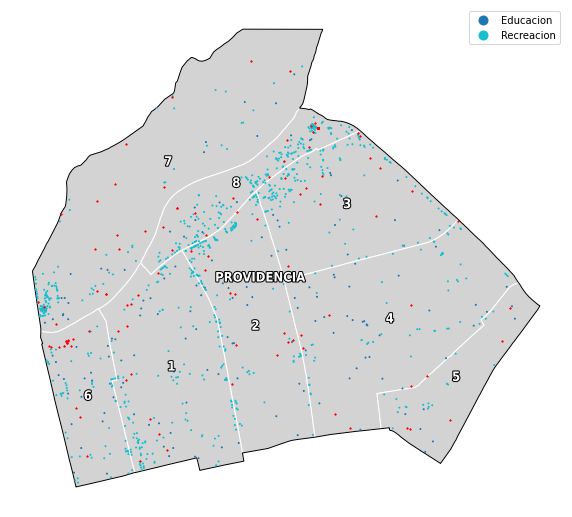

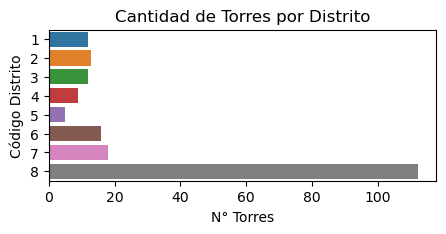

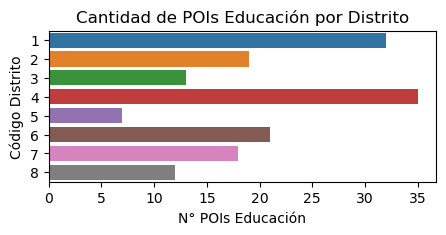

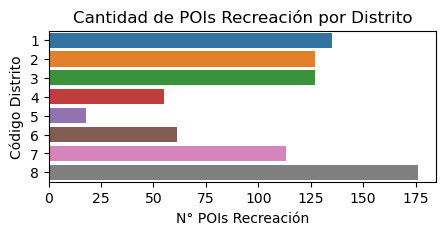

In [67]:
#Comuna
providencia = urban_comunas.copy()
indexNames = providencia[(providencia['NOM_COMUNA'] != 'PROVIDENCIA')].index
providencia.drop(indexNames, inplace =True)

#Distritos
providencia_distritos = urban_distritos.copy()
indexNames = providencia_distritos[(providencia_distritos['NOM_COMUNA'] != 'PROVIDENCIA')].index
providencia_distritos.drop(indexNames, inplace =True)

#Antenas
providencia_torres = torres_gdf.copy()
indexNames = providencia_torres[(providencia_torres['NOM_COMUNA'] != 'PROVIDENCIA')].index
providencia_torres.drop(indexNames, inplace =True)

#Pois
providencia_pois = comunas_l6_pois.copy()
indexNames = providencia_pois[(providencia_pois['NOM_COMUNA'] != 'PROVIDENCIA')].index
providencia_pois.drop(indexNames, inplace =True)

#Visualizacion
ax = providencia_distritos.plot(figsize=(10,10),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = providencia.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = providencia_pois.plot(column='amenity', figsize=(10,10),markersize=1,legend=True,ax=ax)
ax = providencia_torres.plot(marker='*', color='red',markersize=2,ax=ax)


texts = []
for comuna, centroid in zip(providencia['NOM_COMUNA'], providencia.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)

texts = []
for distrito, centroid in zip(providencia_distritos['COD_DISTRI'], providencia_distritos.centroid):
    t = ax.text(centroid.x, centroid.y, distrito, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

####################################################
fig = plt.figure(dpi=100, figsize=(5,2))

providencia_distritos = providencia_distritos.set_crs("EPSG:4326")
providencia_torres_distrito = gpd.sjoin(providencia_torres,providencia_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = providencia_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()

ax1 = fig.gca()
sns.barplot(x=torres_por_distrito.rinhead, y=torres_por_distrito.COD_DISTRI, ax=ax1, orient="h")
ax1.set_ylabel("Código Distrito")
ax1.set_xlabel("N° Torres")
ax1.set_title("Cantidad de Torres por Distrito")
###################################################
fig2 = plt.figure(dpi=100, figsize=(5,2))

providencia_educacion = providencia_pois.copy()
indexNames = providencia_educacion[(providencia_educacion['amenity'] != 'Educacion')].index
providencia_educacion.drop(indexNames, inplace = True)
providencia_educacion_pois = providencia_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 

ax2 = fig2.gca()
sns.barplot(x=providencia_educacion_pois.amenity, y=providencia_educacion_pois.COD_DISTRI, ax=ax2, orient="h")
ax2.set_ylabel("Código Distrito")
ax2.set_xlabel("N° POIs Educación")
ax2.set_title("Cantidad de POIs Educación por Distrito")

##################################################
fig3 = plt.figure(dpi=100, figsize=(5,2))

providencia_recreacion = providencia_pois.copy()
indexNames = providencia_recreacion[(providencia_recreacion['amenity'] != 'Recreacion')].index
providencia_recreacion.drop(indexNames, inplace = True)
providencia_recreacion_pois = providencia_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()

ax3 = fig3.gca()
sns.barplot(x=providencia_recreacion_pois.amenity, y=providencia_recreacion_pois.COD_DISTRI, ax=ax3, orient="h")
ax3.set_ylabel("Código Distrito")
ax3.set_xlabel("N° POIs Recreación")
ax3.set_title("Cantidad de POIs Recreación por Distrito")

### Torres y Pois por distrito

In [60]:
providencia_distritos = providencia_distritos.set_crs("EPSG:4326")
providencia_torres_distrito = gpd.sjoin(providencia_torres,providencia_distritos, how='inner', op = 'intersects').reset_index().drop(['index_right','index'], axis = 1)
torres_por_distrito = providencia_torres_distrito.groupby(['COD_DISTRI']).agg({'rinhead':'count'}).reset_index()
torres_por_distrito.rename(columns={'rinhead':'Torres', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(torres_por_distrito)

   Código Distrito  Torres
0                1      12
1                2      13
2                3      12
3                4       9
4                5       5
5                6      16
6                7      18
7                8     112


In [61]:
providencia_educacion = providencia_pois.copy()
indexNames = providencia_educacion[(providencia_educacion['amenity'] != 'Educacion')].index
providencia_educacion.drop(indexNames, inplace = True)
providencia_educacion_pois = providencia_educacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index() 
providencia_educacion_pois.rename(columns={'amenity':'POIs Educacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(providencia_educacion_pois)

   Código Distrito  POIs Educacion
0                1              32
1                2              19
2                3              13
3                4              35
4                5               7
5                6              21
6                7              18
7                8              12


In [41]:
providencia_recreacion = providencia_pois.copy()
indexNames = providencia_recreacion[(providencia_recreacion['amenity'] != 'Recreacion')].index
providencia_recreacion.drop(indexNames, inplace = True)
providencia_recreacion_pois = providencia_recreacion.groupby(['COD_DISTRI']).agg({'amenity':'count'}).reset_index()
providencia_recreacion_pois.rename(columns={'amenity':'POIs Recreacion', 'COD_DISTRI': 'Código Distrito'}, inplace = True)
print(providencia_recreacion_pois)

   Código Distrito  POIs Recreacion
0                1              135
1                2              127
2                3              127
3                4               55
4                5               18
5                6               61
6                7              113
7                8              176


# ################################################################


### Descubriendo las torres cercanas a la Línea 6 del metro

In [14]:
ruta_gdf.drop(['Unnamed: 0'], axis = 1)

shape_id                                           geometry  \
0  L6-I_V40  LINESTRING (-70.69542 -33.48338, -70.69335 -33...   
1  L6-R_V40  LINESTRING (-70.60817 -33.42077, -70.60981 -33...   

          trip_id route_id service_id  direction_id agency_id  \
0  L6-I-L_V40-M01   L6_V40      L_V40             0         M   
1  L6-R-L_V40-M01   L6_V40      L_V40             1         M   

  route_short_name                  route_long_name  route_desc  route_type  \
0               L6  Línea6 (Cerrillos - Los Leones)         NaN           1   
1               L6  Línea6 (Cerrillos - Los Leones)         NaN           1   

   route_url route_color  route_text_color  
0        NaN      9933FF                 0  
1        NaN      9933FF                 0

In [15]:
ruta_buffer = ruta_gdf.copy()
ruta_buffer = ruta_buffer.set_crs("EPSG:4326")
ruta_buffer.geometry = ruta_buffer['geometry'].buffer(0.001)



<ipython-input-15-350296c7360b>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ruta_buffer.geometry = ruta_buffer['geometry'].buffer(0.001)


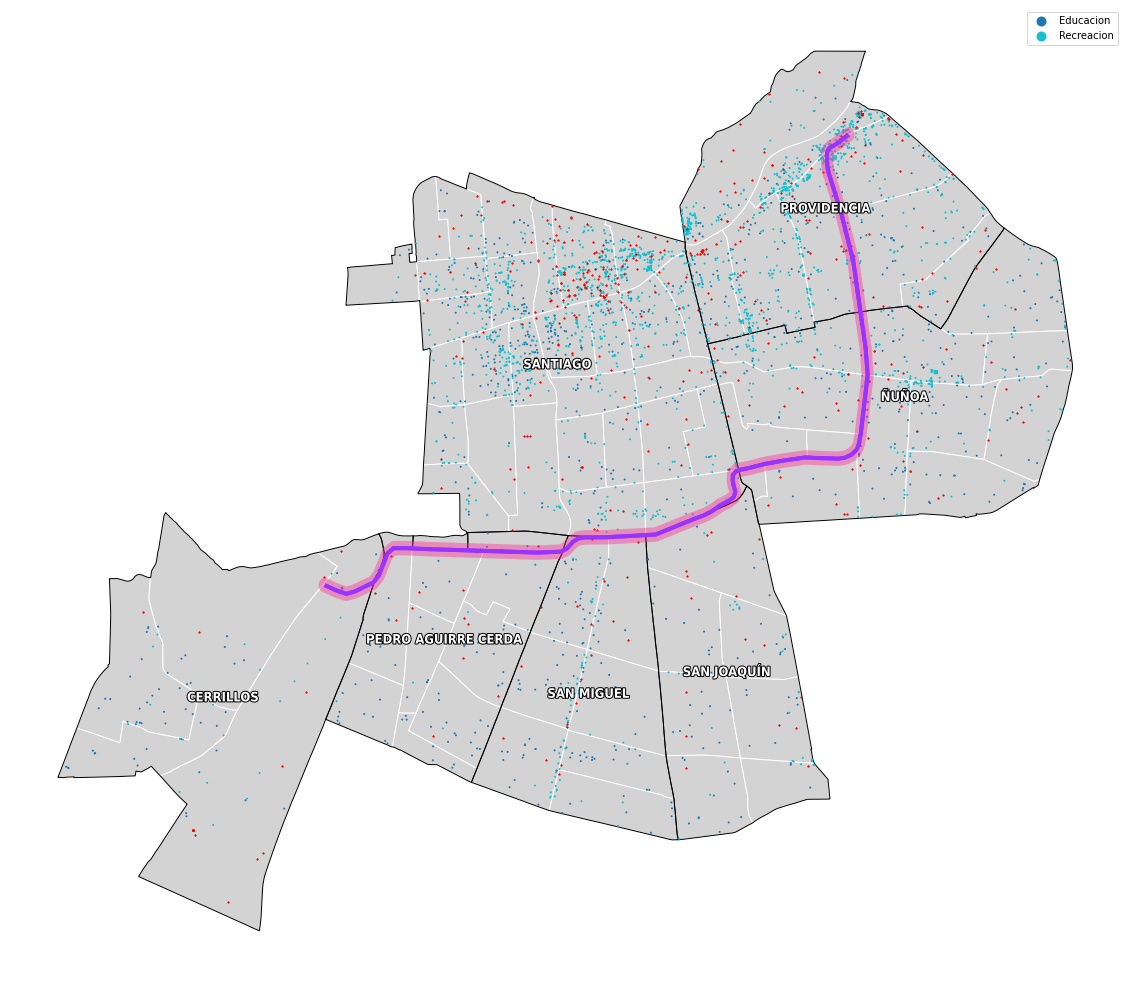

In [16]:
ax = urban_distritos.plot(figsize=(20,20),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = urban_comunas.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = comunas_l6_pois.plot(column='amenity', figsize=(20,20),markersize=1,legend=True,ax=ax)
ax = torres_gdf.plot(marker='*', color='red',markersize=2,ax=ax)
ax = ruta_buffer.plot(color = '#FF339940', linewidth = 1, ax=ax)
ax = ruta_gdf.plot(color='#'+ ruta_gdf.route_color,linewidth=4,ax=ax)



texts = []
for comuna, centroid in zip(urban_comunas['NOM_COMUNA'], urban_comunas.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

In [17]:
ruta_buffer = ruta_gdf.copy()
ruta_buffer = ruta_buffer.set_crs("EPSG:4326")
ruta_buffer.geometry = ruta_buffer['geometry'].buffer(0.01)

<ipython-input-17-3f4212cec20f>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ruta_buffer.geometry = ruta_buffer['geometry'].buffer(0.01)


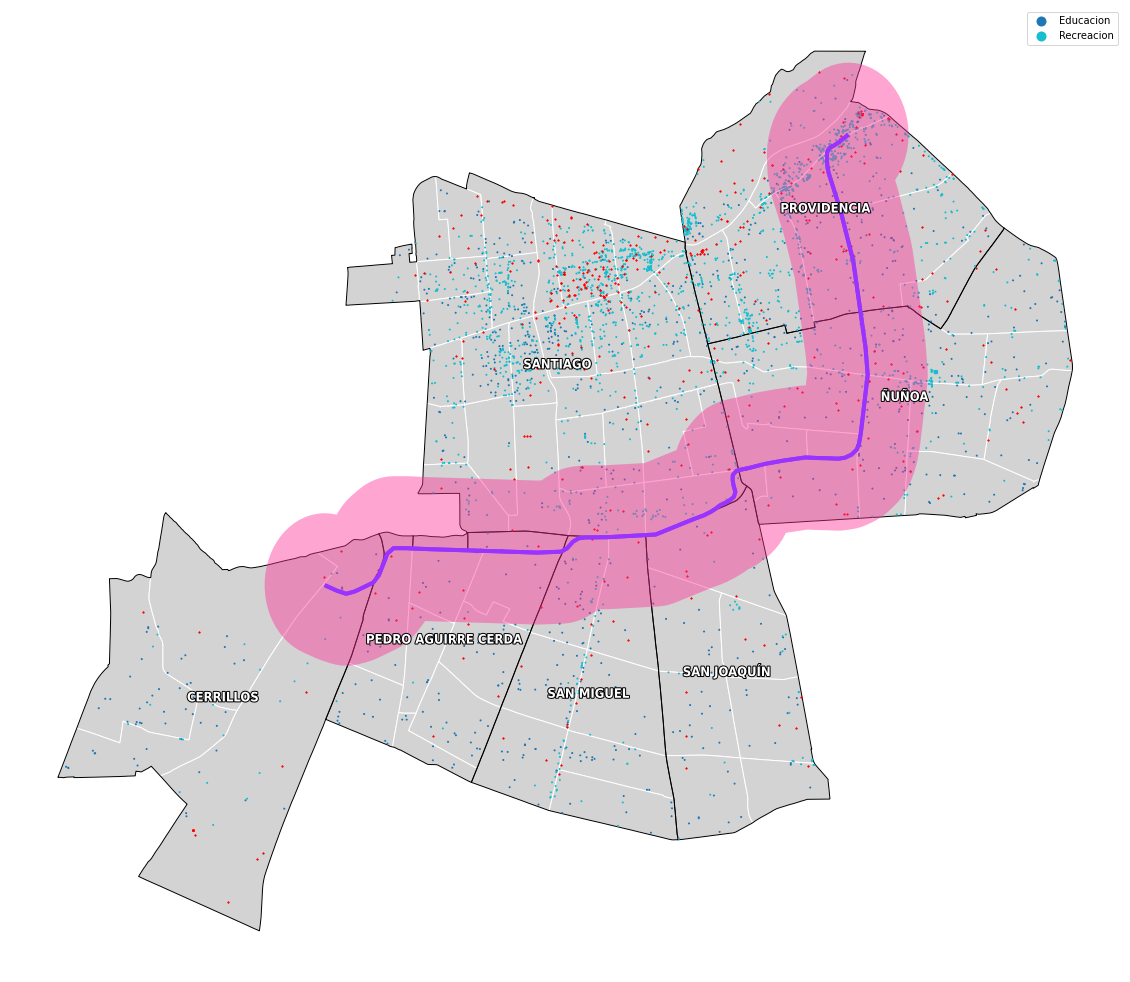

In [18]:
ax = urban_distritos.plot(figsize=(20,20),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = urban_comunas.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = comunas_l6_pois.plot(column='amenity', figsize=(20,20),markersize=1,legend=True,ax=ax)
ax = torres_gdf.plot(marker='*', color='red',markersize=2,ax=ax)
ax = ruta_buffer.plot(color = '#FF339940', linewidth = 1, ax=ax)
ax = ruta_gdf.plot(color='#'+ ruta_gdf.route_color,linewidth=4,ax=ax)



texts = []
for comuna, centroid in zip(urban_comunas['NOM_COMUNA'], urban_comunas.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');

In [21]:
torres_buffer = torres_gdf.copy()
torres_buffer = torres_buffer.set_crs("EPSG:4326")
torres_buffer.geometry = torres_buffer['geometry'].buffer(0.01)

<ipython-input-21-872c8b5bd1e6>:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  torres_buffer.geometry = torres_buffer['geometry'].buffer(0.01)


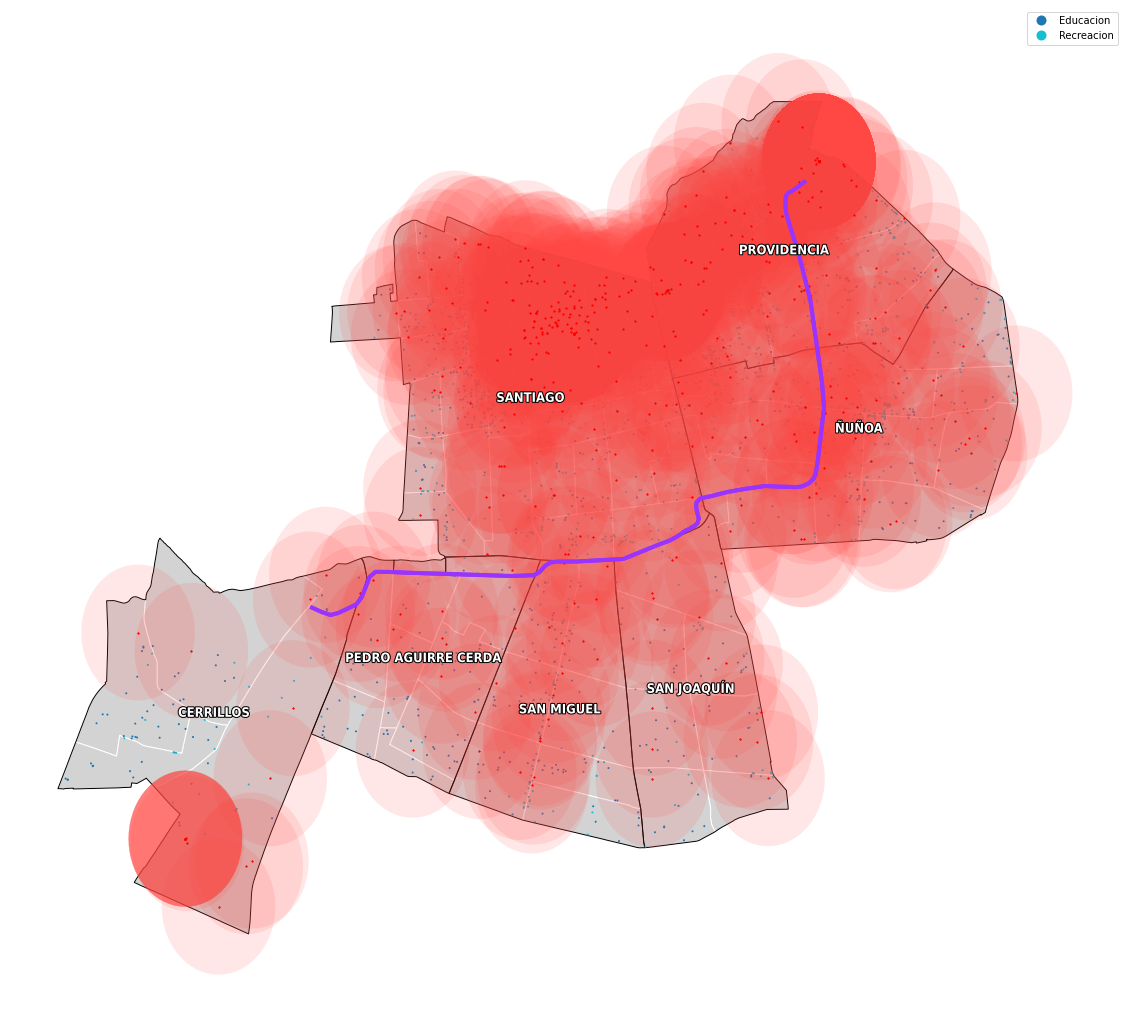

In [30]:
ax = urban_distritos.plot(figsize=(20,20),linewidth=1, edgecolor='white', facecolor='lightgray')
ax = urban_comunas.plot(linewidth=1, edgecolor='black', facecolor="none", ax=ax)
ax = comunas_l6_pois.plot(column='amenity', figsize=(20,20),markersize=1,legend=True,ax=ax)
ax = torres_buffer.plot(color='#FF444020',linewidth=1,ax=ax)
ax = torres_gdf.plot(marker='*', color='red',markersize=2,ax=ax)

ax = ruta_gdf.plot(color='#'+ ruta_gdf.route_color,linewidth=4,ax=ax)



texts = []
for comuna, centroid in zip(urban_comunas['NOM_COMUNA'], urban_comunas.centroid):
    t = ax.text(centroid.x, centroid.y, comuna, **text_style)
    t.set_path_effects(text_effects)
    texts.append(t)
adjust_text(texts, autoalign='y', lim=1)
    
ax.axis('off');